<a href="https://colab.research.google.com/github/Arijit20031/Assignment/blob/main/Assignment-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

STOCK MARKET NETWORK ANALYSIS - NIFTY 100

1. Loading stock list...
Loaded 100 stocks from ind_nifty100list.csv

2. Data Collection...
Loading local data...
Loaded local data: 494 days, 100 stocks
Date range: 2023-11-08 00:00:00 to 2025-11-07 00:00:00

Calculating returns...

Data availability for top 10 stocks:
ADANIGREEN.NS    1.0
ADANIENT.NS      1.0
AMBUJACEM.NS     1.0
ADANIPOWER.NS    1.0
DMART.NS         1.0
DRREDDY.NS       1.0
APOLLOHOSP.NS    1.0
ASIANPAINT.NS    1.0
BAJAJ-AUTO.NS    1.0
AXISBANK.NS      1.0
dtype: float64

Keeping 94 stocks with at least 80.0% data

Returns shape: (493, 94)
Date range: 2023-11-09 00:00:00 to 2025-11-07 00:00:00

4. Creating network...

Creating correlation network from 493 days and 94 stocks...

Network Statistics (threshold=0.5):
Number of nodes: 94
Number of edges: 257
Density: 0.0588

5. Network Analysis...

--- Centrality Analysis ---

--- Clustering Analysis ---

Clustering Analysis:
Average Clustering Coefficient: 0.3857
Global Cluster

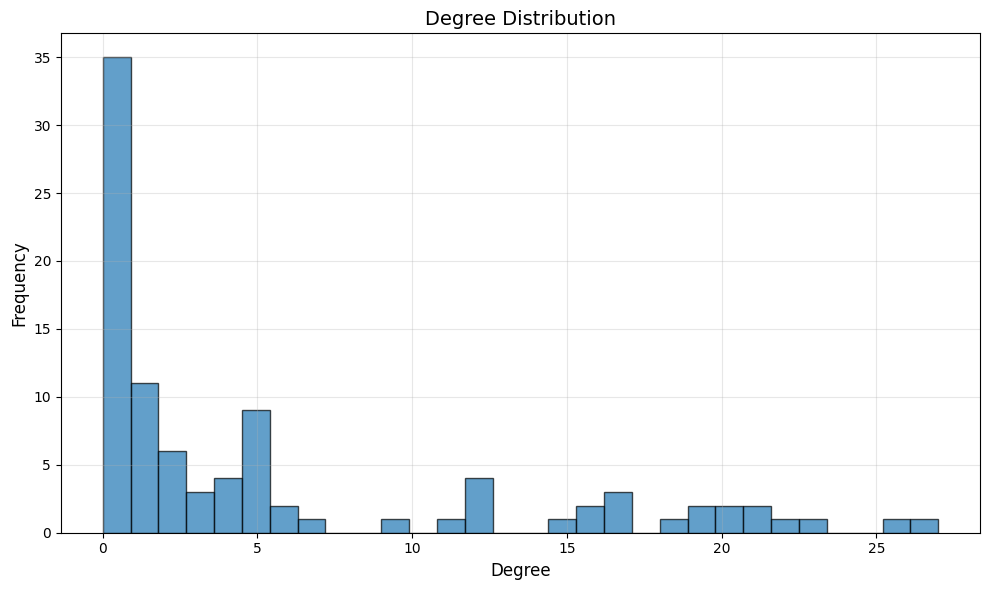

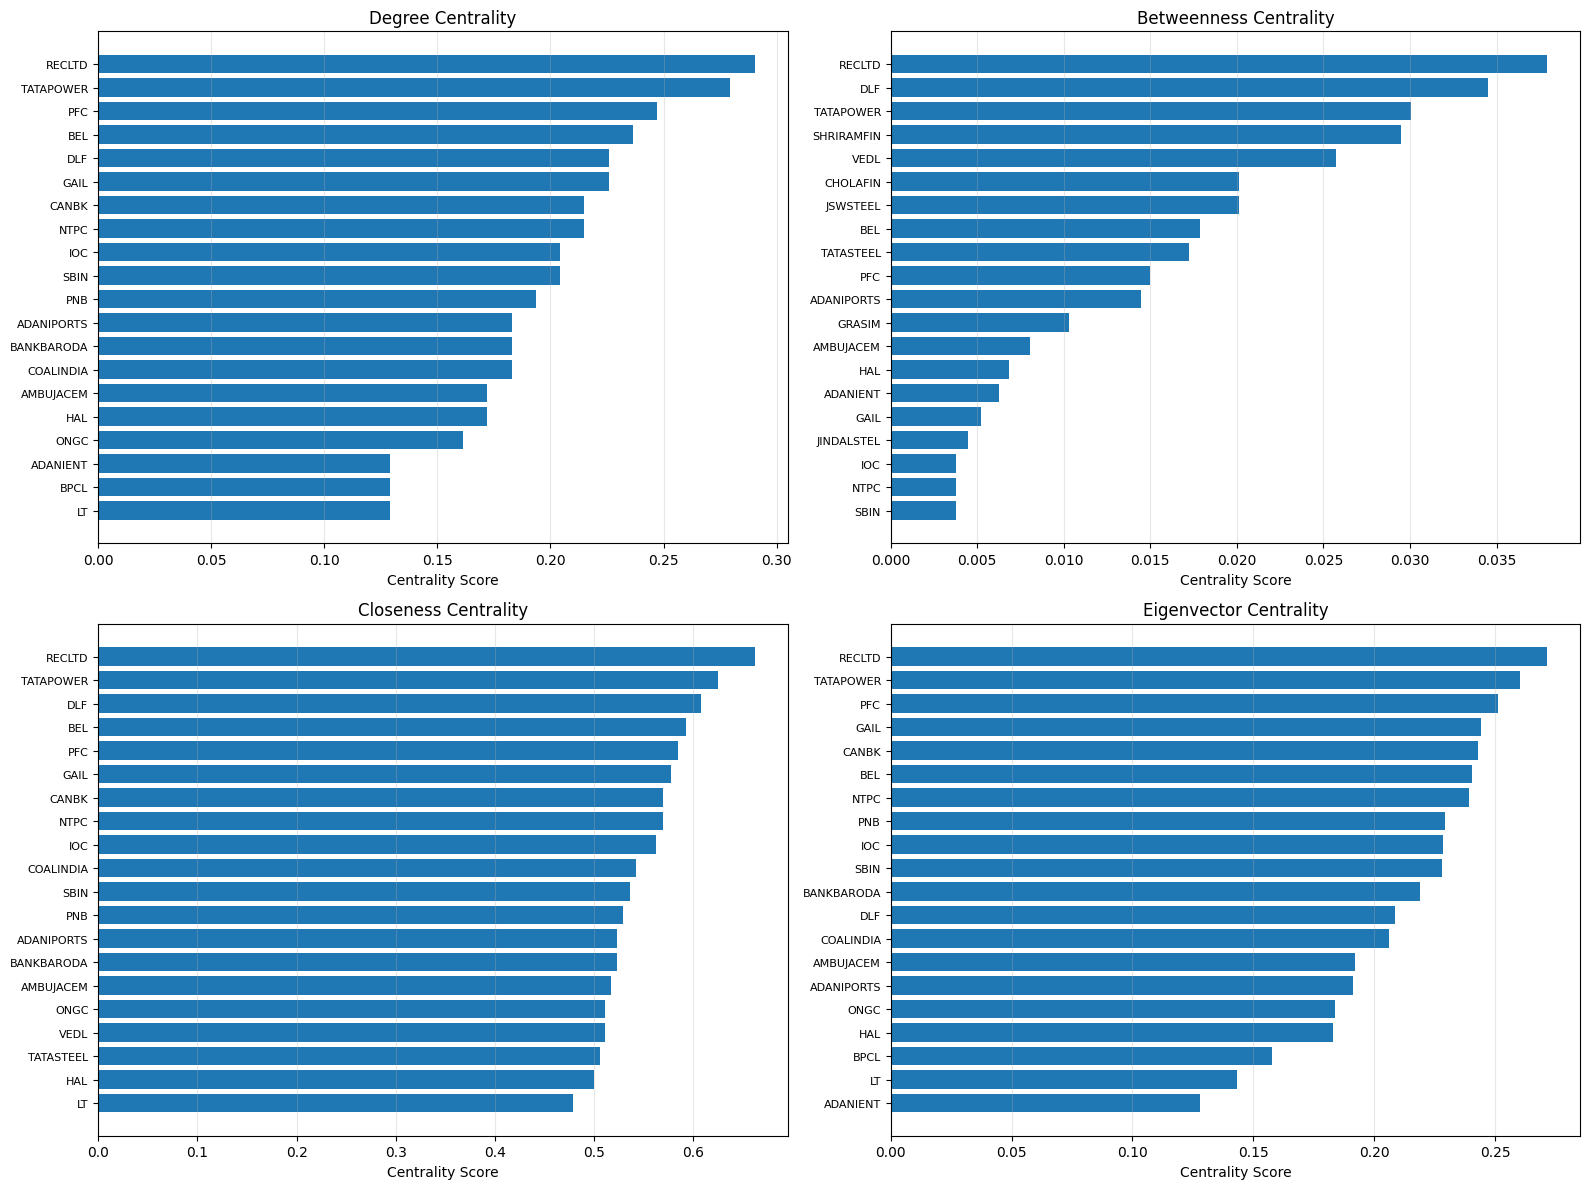

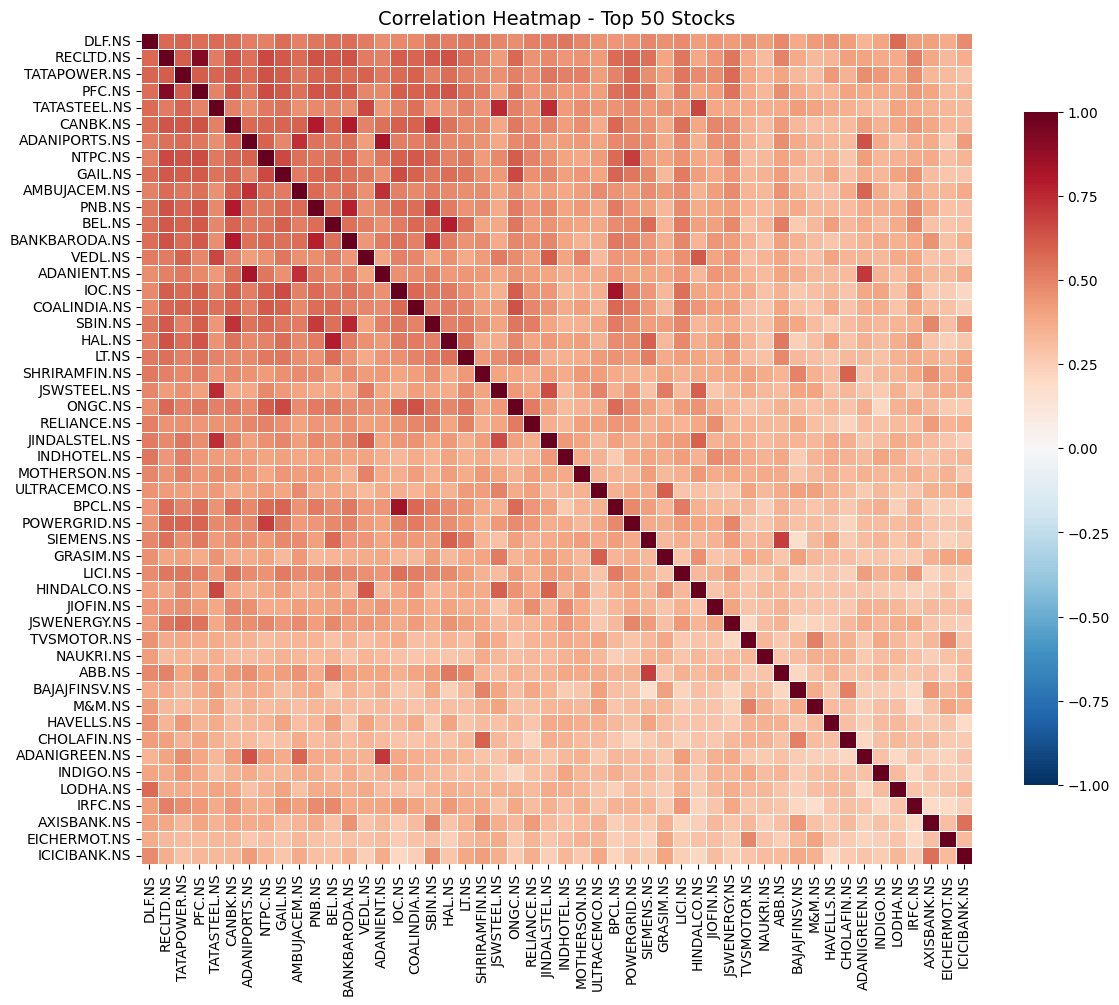

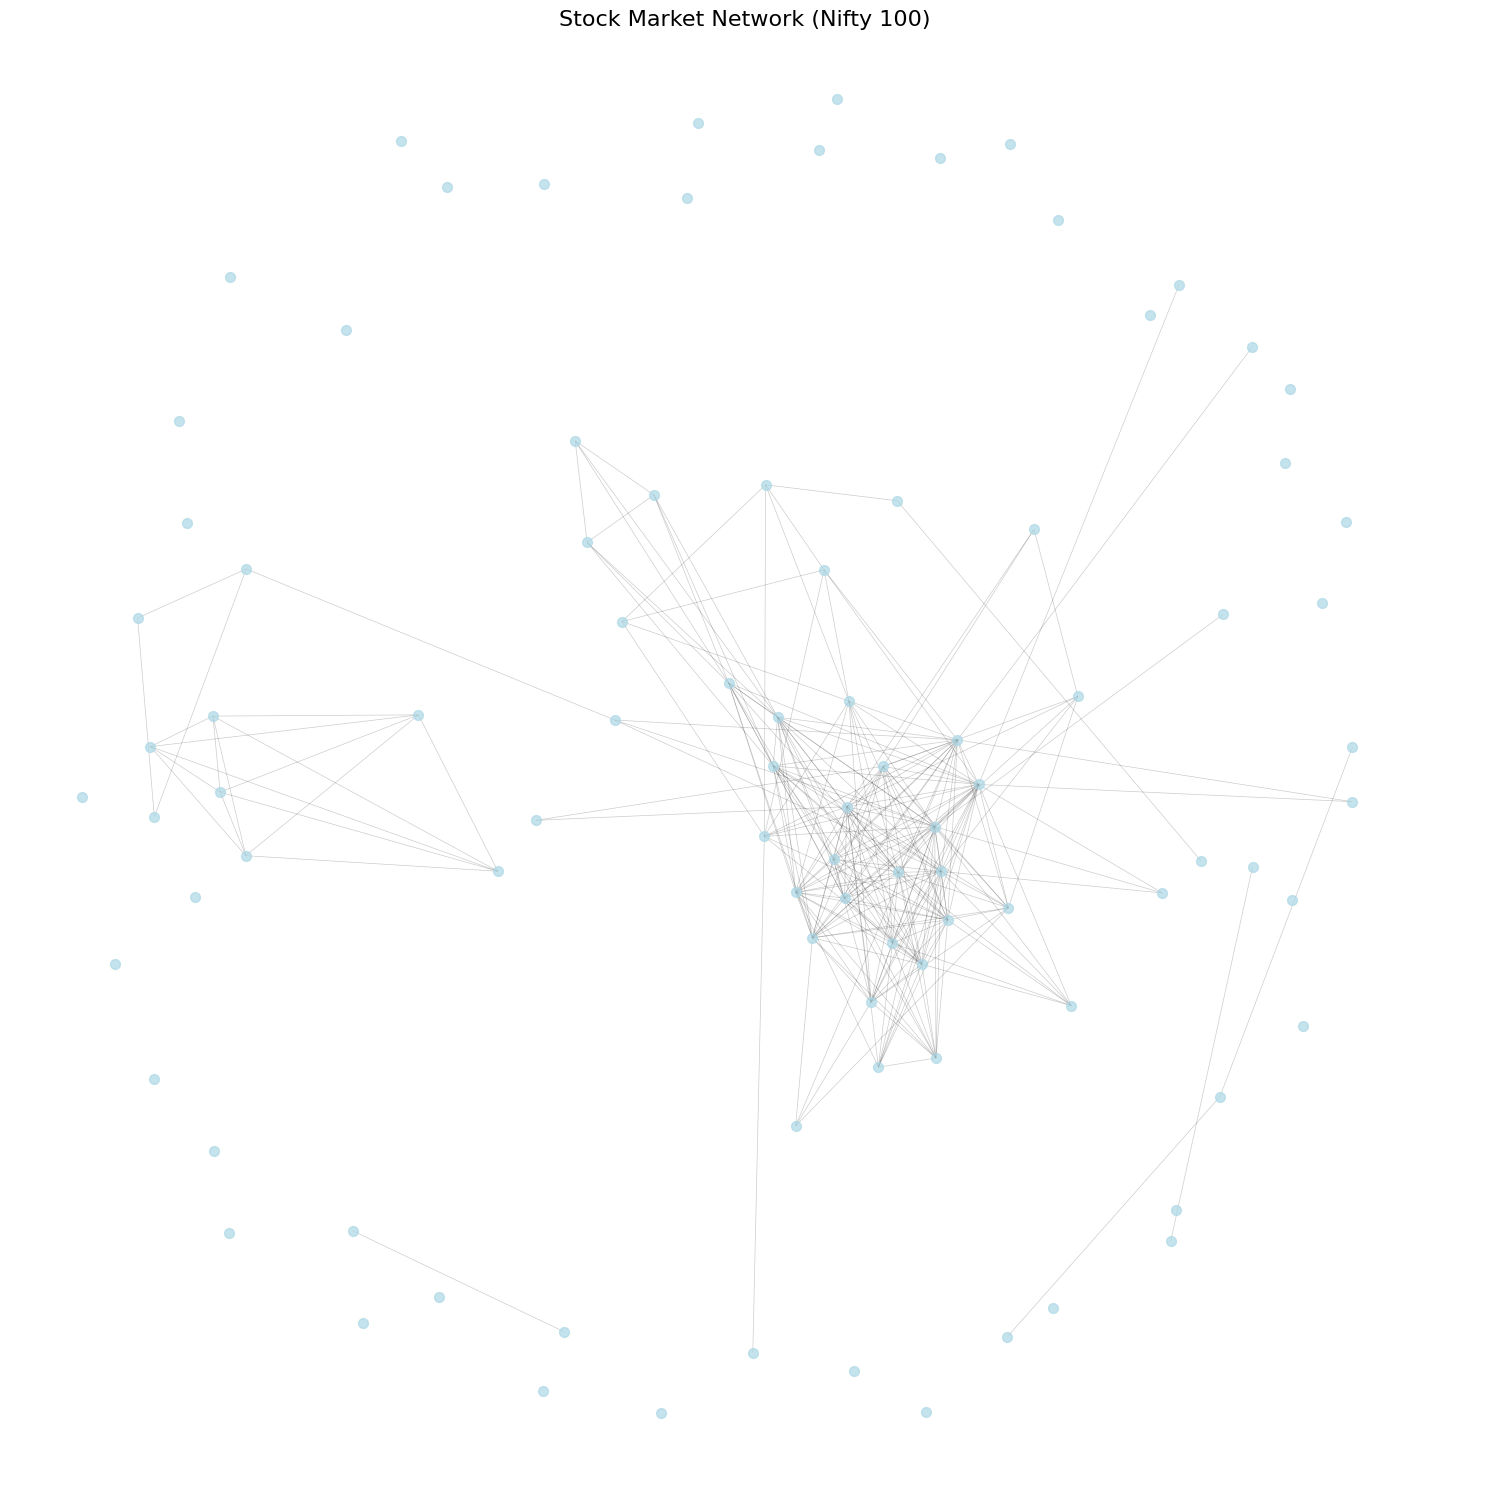


7. Conducting threshold study...

Creating correlation network from 493 days and 94 stocks...

Network Statistics (threshold=0.3):
Number of nodes: 94
Number of edges: 1480
Density: 0.3386

Creating correlation network from 493 days and 94 stocks...

Network Statistics (threshold=0.4):
Number of nodes: 94
Number of edges: 628
Density: 0.1437

Creating correlation network from 493 days and 94 stocks...

Network Statistics (threshold=0.5):
Number of nodes: 94
Number of edges: 257
Density: 0.0588

Creating correlation network from 493 days and 94 stocks...

Network Statistics (threshold=0.6):
Number of nodes: 94
Number of edges: 73
Density: 0.0167

Creating correlation network from 493 days and 94 stocks...

Network Statistics (threshold=0.7):
Number of nodes: 94
Number of edges: 19
Density: 0.0043

Creating correlation network from 493 days and 94 stocks...

Network Statistics (threshold=0.8):
Number of nodes: 94
Number of edges: 4
Density: 0.0009

Threshold Study Results:
 threshold  n

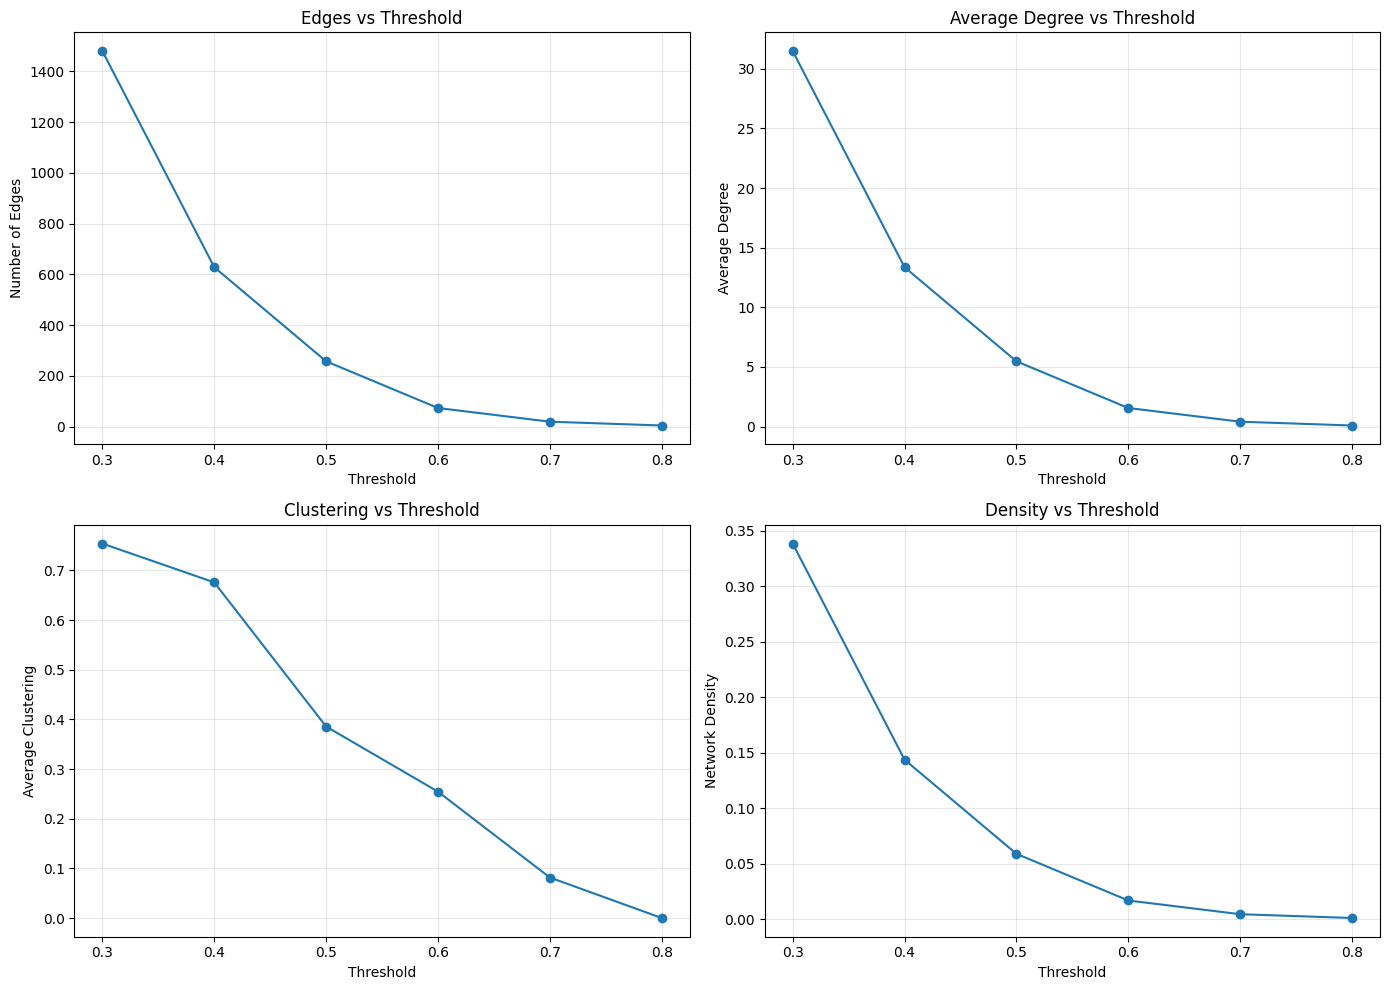


8. Creating MST network...

MST Network Statistics:
Number of nodes: 94
Number of edges: 93

ANALYSIS COMPLETE!


In [5]:
"""
Stock Market Network Analysis - Indian Stock Market (Nifty 100)
ECS414/614 Network Science Assignment 2

This script creates and analyzes a stock correlation network from Indian stock market data.
"""

import pandas as pd
import numpy as np
import yfinance as yf
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import os
warnings.filterwarnings('ignore')

# ===========================
# 1. DATA COLLECTION
# ===========================

def load_stock_list(csv_file='ind_nifty100list.csv'):
    """Load the list of stocks from CSV file"""
    try:
        df = pd.read_csv(csv_file)
        # Remove dummy stocks if any
        df = df[~df['Symbol'].str.contains('DUMMY', case=False, na=False)]
        # Add .NS suffix for NSE stocks
        df['Yahoo_Symbol'] = df['Symbol'] + '.NS'
        print(f"Loaded {len(df)} stocks from {csv_file}")
        return df
    except Exception as e:
        print(f"Error loading stock list: {e}")
        return None

def download_stock_data(symbols, start_date, end_date, filename='stock_data_nifty100.csv'):
    """
    Download historical stock data from Yahoo Finance

    Parameters:
    - symbols: list of stock symbols
    - start_date: start date for data
    - end_date: end date for data
    - filename: name to save the data
    """
    print(f"Downloading data for {len(symbols)} stocks from {start_date.date()} to {end_date.date()}...")

    # Download data
    data = yf.download(symbols, start=start_date, end=end_date, progress=True)

    # Handle different data structures
    if isinstance(data.columns, pd.MultiIndex):
        if 'Adj Close' in data.columns.get_level_values(0):
            prices = data['Adj Close']
        elif 'Close' in data.columns.get_level_values(0):
            prices = data['Close']
        else:
            prices = data.iloc[:, data.columns.get_level_values(0)[0]]
    else:
        if 'Adj Close' in data.columns:
            prices = data['Adj Close']
        elif 'Close' in data.columns:
            prices = data['Close']
        else:
            prices = data.iloc[:, 0]

    # Remove any columns with all NaN values
    prices = prices.dropna(axis=1, how='all')

    print(f"\nFinal prices data shape: {prices.shape}")

    # Save to CSV
    prices.to_csv(filename)
    print(f"Data saved to {filename}")

    return prices

def load_local_data(filename='stock_data_nifty100.csv'):
    """Load previously downloaded stock data"""
    try:
        prices = pd.read_csv(filename, index_col=0, parse_dates=True)
        print(f"Loaded local data: {prices.shape[0]} days, {prices.shape[1]} stocks")
        print(f"Date range: {prices.index.min()} to {prices.index.max()}")

        # Check for duplicate dates
        if prices.index.duplicated().any():
            prices = prices[~prices.index.duplicated(keep='first')]

        # Sort by date
        if not prices.index.is_monotonic_increasing:
            prices = prices.sort_index()

        # Remove all NaN rows
        prices = prices[~prices.isna().all(axis=1)]

        return prices
    except FileNotFoundError:
        print(f"Local file {filename} not found. Please download data first.")
        return None
    except Exception as e:
        print(f"Error loading local data: {e}")
        return None

# ===========================
# 2. NETWORK CREATION
# ===========================

def calculate_returns(prices, min_data_ratio=0.8):
    """
    Calculate daily returns from prices with robust handling of missing data

    Parameters:
    - prices: DataFrame of stock prices
    - min_data_ratio: minimum ratio of non-NaN data required for a stock to be included

    Returns:
    - returns: DataFrame of stock returns
    """
    print("\nCalculating returns...")

    # Ensure prices are sorted by date
    if not prices.index.is_monotonic_increasing:
        prices = prices.sort_index()

    # Calculate data availability for each stock
    data_availability = prices.count() / len(prices)
    print(f"\nData availability for top 10 stocks:")
    print(data_availability.sort_values(ascending=False).head(10))

    # Filter stocks with sufficient data
    valid_stocks = data_availability[data_availability >= min_data_ratio].index
    print(f"\nKeeping {len(valid_stocks)} stocks with at least {min_data_ratio*100}% data")

    # Keep only valid stocks
    prices_filtered = prices[valid_stocks]

    # Calculate percentage change
    returns = prices_filtered.pct_change()

    # Remove the first row (which will be NaN)
    returns = returns.iloc[1:]

    print(f"\nReturns shape: {returns.shape}")
    print(f"Date range: {returns.index.min()} to {returns.index.max()}")

    # Check for remaining NaN values
    nan_counts = returns.isna().sum()
    if nan_counts.sum() > 0:
        print(f"\nWarning: Found {nan_counts.sum()} remaining NaN values in returns")
        print("Top 5 stocks with most NaNs:")
        print(nan_counts.sort_values(ascending=False).head())

        # Option 1: Fill remaining NaNs with 0 (conservative approach)
        returns = returns.fillna(0)
        print("Filled remaining NaN values with 0")

        # Option 2: Alternatively, you could drop rows with any NaNs:
        # returns = returns.dropna()
        # print("Dropped rows with any NaN values")

    return returns

def create_correlation_network(returns, threshold=0.5):
    """
    Create a network based on correlation between stock returns

    Parameters:
    - returns: DataFrame of stock returns
    - threshold: correlation threshold for edge creation

    Returns:
    - G: NetworkX graph
    - corr_matrix: correlation matrix
    """
    if returns.empty or returns.shape[0] < 2 or returns.shape[1] < 2:
        print("Warning: Insufficient data for correlation analysis")
        return nx.Graph(), pd.DataFrame()

    print(f"\nCreating correlation network from {returns.shape[0]} days and {returns.shape[1]} stocks...")

    # Calculate correlation matrix
    corr_matrix = returns.corr()

    # Handle any remaining NaN values
    corr_matrix = corr_matrix.fillna(0)

    # Create graph
    G = nx.Graph()

    # Add nodes
    stocks = corr_matrix.columns
    for stock in stocks:
        G.add_node(stock)

    # Add edges based on correlation threshold
    edges_added = 0
    for i, stock1 in enumerate(stocks):
        for j, stock2 in enumerate(stocks):
            if i < j:  # Avoid duplicate edges
                corr_value = corr_matrix.loc[stock1, stock2]
                if abs(corr_value) >= threshold:
                    G.add_edge(stock1, stock2, weight=corr_value)
                    edges_added += 1

    print(f"\nNetwork Statistics (threshold={threshold}):")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {edges_added}")
    print(f"Density: {nx.density(G):.4f}")

    return G, corr_matrix

def create_mst_network(returns):
    """
    Create Minimum Spanning Tree network (distance-based)

    Parameters:
    - returns: DataFrame of stock returns

    Returns:
    - MST: NetworkX graph (Minimum Spanning Tree)
    """
    if returns.empty or returns.shape[0] < 2 or returns.shape[1] < 2:
        print("Warning: Insufficient data for MST analysis")
        return nx.Graph()

    corr_matrix = returns.corr()
    corr_matrix = corr_matrix.fillna(0)

    # Convert correlation to distance
    distance_matrix = np.sqrt(2 * (1 - corr_matrix))

    # Create complete graph with distances as weights
    G = nx.Graph()
    stocks = corr_matrix.columns

    for i, stock1 in enumerate(stocks):
        for j, stock2 in enumerate(stocks):
            if i < j:
                dist = distance_matrix.loc[stock1, stock2]
                G.add_edge(stock1, stock2, weight=dist)

    # Get MST
    MST = nx.minimum_spanning_tree(G)

    print(f"\nMST Network Statistics:")
    print(f"Number of nodes: {MST.number_of_nodes()}")
    print(f"Number of edges: {MST.number_of_edges()}")

    return MST

# ===========================
# 3. NETWORK ANALYSIS
# ===========================

def analyze_centrality(G):
    """Calculate various centrality measures"""

    if G.number_of_nodes() == 0:
        print("Warning: Empty graph - cannot calculate centrality")
        return {'degree': {}, 'betweenness': {}, 'closeness': {}, 'eigenvector': {}}

    centrality_measures = {}

    # Degree Centrality
    centrality_measures['degree'] = nx.degree_centrality(G)

    # Betweenness Centrality
    centrality_measures['betweenness'] = nx.betweenness_centrality(G)

    # Closeness Centrality
    if nx.is_connected(G):
        centrality_measures['closeness'] = nx.closeness_centrality(G)
    else:
        # For disconnected graphs, calculate for largest component
        largest_cc = max(nx.connected_components(G), key=len)
        G_largest = G.subgraph(largest_cc)
        centrality_measures['closeness'] = nx.closeness_centrality(G_largest)

    # Eigenvector Centrality
    try:
        centrality_measures['eigenvector'] = nx.eigenvector_centrality(G, max_iter=1000)
    except:
        print("Eigenvector centrality failed to converge")
        centrality_measures['eigenvector'] = {node: 0 for node in G.nodes()}

    return centrality_measures

def analyze_clustering(G):
    """Calculate clustering coefficients"""

    if G.number_of_nodes() == 0:
        print("Warning: Empty graph - cannot calculate clustering")
        return {}, 0, 0

    # Local clustering coefficient
    local_clustering = nx.clustering(G)

    # Average clustering coefficient
    avg_clustering = nx.average_clustering(G)

    # Global clustering coefficient (transitivity)
    global_clustering = nx.transitivity(G)

    print(f"\nClustering Analysis:")
    print(f"Average Clustering Coefficient: {avg_clustering:.4f}")
    print(f"Global Clustering Coefficient: {global_clustering:.4f}")

    return local_clustering, avg_clustering, global_clustering

def analyze_degree_distribution(G):
    """Analyze degree distribution"""

    if G.number_of_nodes() == 0:
        print("Warning: Empty graph - cannot analyze degree distribution")
        return [], pd.Series()

    degrees = [G.degree(n) for n in G.nodes()]
    degree_counts = pd.Series(degrees).value_counts().sort_index()

    print(f"\nDegree Distribution:")
    print(f"Average Degree: {np.mean(degrees):.2f}")
    print(f"Max Degree: {np.max(degrees)}")
    print(f"Min Degree: {np.min(degrees)}")

    return degrees, degree_counts

def analyze_assortativity(G):
    """Calculate assortativity coefficient"""

    if G.number_of_nodes() == 0:
        print("Warning: Empty graph - cannot calculate assortativity")
        return None

    try:
        assortativity = nx.degree_assortativity_coefficient(G)
        print(f"\nDegree Assortativity: {assortativity:.4f}")
        return assortativity
    except:
        print("Could not calculate assortativity")
        return None

def analyze_components(G):
    """Analyze connected components"""

    if G.number_of_nodes() == 0:
        print("Warning: Empty graph - no components")
        return 0, 0

    if nx.is_connected(G):
        print("\nNetwork is fully connected")
        num_components = 1
        largest_component_size = G.number_of_nodes()
    else:
        components = list(nx.connected_components(G))
        num_components = len(components)
        largest_component_size = len(max(components, key=len))

        print(f"\nConnected Components: {num_components}")
        print(f"Largest Component Size: {largest_component_size}")

    return num_components, largest_component_size

# ===========================
# 4. VISUALIZATION
# ===========================

def plot_degree_distribution(degrees):
    """Plot degree distribution"""

    if not degrees:
        print("No degrees to plot")
        return

    plt.figure(figsize=(10, 6))
    plt.hist(degrees, bins=30, edgecolor='black', alpha=0.7)
    plt.xlabel('Degree', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Degree Distribution', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('degree_distribution_nifty100.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_centrality_comparison(centrality_measures, top_n=20):
    """Plot top nodes by different centrality measures"""

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    measures = ['degree', 'betweenness', 'closeness', 'eigenvector']
    titles = ['Degree Centrality', 'Betweenness Centrality',
              'Closeness Centrality', 'Eigenvector Centrality']

    for idx, (measure, title) in enumerate(zip(measures, titles)):
        ax = axes[idx // 2, idx % 2]

        if centrality_measures[measure] and len(centrality_measures[measure]) > 0:
            # Get top N nodes
            sorted_nodes = sorted(centrality_measures[measure].items(),
                                 key=lambda x: x[1], reverse=True)[:top_n]
            nodes, values = zip(*sorted_nodes)

            # Clean node names (remove .NS)
            clean_nodes = [n.replace('.NS', '') for n in nodes]

            ax.barh(range(len(nodes)), values)
            ax.set_yticks(range(len(nodes)))
            ax.set_yticklabels(clean_nodes, fontsize=8)
            ax.invert_yaxis()
            ax.set_xlabel('Centrality Score', fontsize=10)
            ax.set_title(title, fontsize=12)
            ax.grid(True, alpha=0.3, axis='x')
        else:
            ax.text(0.5, 0.5, f'No data for {title}',
                   ha='center', va='center', transform=ax.transAxes)

    plt.tight_layout()
    plt.savefig('centrality_comparison_nifty100.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_correlation_heatmap(corr_matrix, top_n=50):
    """Plot correlation heatmap for top N stocks"""

    if corr_matrix.empty:
        print("No correlation matrix to plot")
        return

    # Select top N stocks by average correlation
    avg_corr = corr_matrix.mean().sort_values(ascending=False)
    top_stocks = avg_corr.head(min(top_n, len(avg_corr))).index

    # Create subset correlation matrix
    corr_subset = corr_matrix.loc[top_stocks, top_stocks]

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_subset, cmap='RdBu_r', center=0, vmin=-1, vmax=1,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    plt.title(f'Correlation Heatmap - Top {len(top_stocks)} Stocks', fontsize=14)
    plt.tight_layout()
    plt.savefig('correlation_heatmap_nifty100.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_network(G, layout='spring', node_size=50, figsize=(15, 15)):
    """Visualize the network"""

    if G.number_of_nodes() == 0:
        print("Empty network - cannot visualize")
        return

    plt.figure(figsize=figsize)

    if layout == 'spring':
        pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)
    elif layout == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(G)
    else:
        pos = nx.circular_layout(G)

    # Draw network
    nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5)
    nx.draw_networkx_nodes(G, pos, node_size=node_size,
                          node_color='lightblue', alpha=0.7)

    plt.title('Stock Market Network (Nifty 100)', fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('network_visualization_nifty100.png', dpi=300, bbox_inches='tight')
    plt.show()

# ===========================
# 5. PARAMETER STUDY
# ===========================

def threshold_study(returns, thresholds=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8]):
    """Study how network properties change with correlation threshold"""

    if returns.empty:
        print("No returns data for threshold study")
        return pd.DataFrame()

    results = []

    for threshold in thresholds:
        G, _ = create_correlation_network(returns, threshold=threshold)

        if G.number_of_nodes() == 0:
            continue

        degrees = [G.degree(n) for n in G.nodes()]
        avg_clustering = nx.average_clustering(G)

        if nx.is_connected(G):
            num_components = 1
            largest_component_size = G.number_of_nodes()
            diameter = nx.diameter(G)
            avg_path_length = nx.average_shortest_path_length(G)
        else:
            components = list(nx.connected_components(G))
            num_components = len(components)
            largest_component_size = len(max(components, key=len))
            largest_cc = max(components, key=len)
            G_largest = G.subgraph(largest_cc)
            diameter = nx.diameter(G_largest)
            avg_path_length = nx.average_shortest_path_length(G_largest)

        results.append({
            'threshold': threshold,
            'num_edges': G.number_of_edges(),
            'density': nx.density(G),
            'avg_degree': np.mean(degrees),
            'avg_clustering': avg_clustering,
            'num_components': num_components,
            'largest_component_size': largest_component_size,
            'diameter': diameter,
            'avg_path_length': avg_path_length
        })

    results_df = pd.DataFrame(results)
    print("\nThreshold Study Results:")
    print(results_df.to_string(index=False))

    # Plot results
    if len(results_df) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        axes[0, 0].plot(results_df['threshold'], results_df['num_edges'], 'o-')
        axes[0, 0].set_xlabel('Threshold')
        axes[0, 0].set_ylabel('Number of Edges')
        axes[0, 0].set_title('Edges vs Threshold')
        axes[0, 0].grid(True, alpha=0.3)

        axes[0, 1].plot(results_df['threshold'], results_df['avg_degree'], 'o-')
        axes[0, 1].set_xlabel('Threshold')
        axes[0, 1].set_ylabel('Average Degree')
        axes[0, 1].set_title('Average Degree vs Threshold')
        axes[0, 1].grid(True, alpha=0.3)

        axes[1, 0].plot(results_df['threshold'], results_df['avg_clustering'], 'o-')
        axes[1, 0].set_xlabel('Threshold')
        axes[1, 0].set_ylabel('Average Clustering')
        axes[1, 0].set_title('Clustering vs Threshold')
        axes[1, 0].grid(True, alpha=0.3)

        axes[1, 1].plot(results_df['threshold'], results_df['density'], 'o-')
        axes[1, 1].set_xlabel('Threshold')
        axes[1, 1].set_ylabel('Network Density')
        axes[1, 1].set_title('Density vs Threshold')
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('threshold_study_nifty100.png', dpi=300, bbox_inches='tight')
        plt.show()

    return results_df

# ===========================
# 6. MAIN EXECUTION
# ===========================

def main():
    """Main execution function"""

    print("=" * 60)
    print("STOCK MARKET NETWORK ANALYSIS - NIFTY 100")
    print("=" * 60)

    # Step 1: Load stock list
    print("\n1. Loading stock list...")
    stock_df = load_stock_list('ind_nifty100list.csv')
    if stock_df is None:
        print("Failed to load stock list. Exiting.")
        return None, None, None, None

    # Step 2: Download or load data
    symbols = stock_df['Yahoo_Symbol'].tolist()
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365)  # 1 year of data as requested

    print("\n2. Data Collection...")

    # Check if local data exists
    if os.path.exists('stock_data_nifty100.csv'):
        print("Loading local data...")
        prices = load_local_data('stock_data_nifty100.csv')
    else:
        print("Local data not found. Downloading from Yahoo Finance...")
        prices = download_stock_data(symbols, start_date, end_date)

    if prices is None or prices.empty:
        print("No price data available. Exiting.")
        return None, None, None, None

    # Step 3: Calculate returns
    returns = calculate_returns(prices, min_data_ratio=0.8)

    if returns.empty:
        print("No returns data available. Exiting.")
        return None, None, None, None

    # Step 4: Create network
    print("\n4. Creating network...")
    threshold = 0.5
    G, corr_matrix = create_correlation_network(returns, threshold=threshold)

    if G.number_of_nodes() == 0:
        print("Network has no nodes. Try lowering the threshold.")
        return None, None, None, None

    # Step 5: Network Analysis
    print("\n5. Network Analysis...")

    print("\n--- Centrality Analysis ---")
    centrality_measures = analyze_centrality(G)

    print("\n--- Clustering Analysis ---")
    local_clustering, avg_clustering, global_clustering = analyze_clustering(G)

    print("\n--- Degree Distribution ---")
    degrees, degree_counts = analyze_degree_distribution(G)

    print("\n--- Assortativity ---")
    assortativity = analyze_assortativity(G)

    print("\n--- Components ---")
    num_components, largest_component_size = analyze_components(G)

    # Step 6: Visualization
    print("\n6. Creating visualizations...")
    plot_degree_distribution(degrees)
    plot_centrality_comparison(centrality_measures)
    plot_correlation_heatmap(corr_matrix)
    plot_network(G)

    # Step 7: Parameter Study
    print("\n7. Conducting threshold study...")
    threshold_results = threshold_study(returns)

    # Step 8: MST Network (Alternative approach)
    print("\n8. Creating MST network...")
    MST = create_mst_network(returns)

    print("\n" + "=" * 60)
    print("ANALYSIS COMPLETE!")
    print("=" * 60)

    return G, corr_matrix, centrality_measures, returns

if __name__ == "__main__":
    G, corr_matrix, centrality_measures, returns = main()

STOCK MARKET NETWORK ANALYSIS - NIFTY 100

1. Loading stock list...
Loaded 100 stocks from ind_nifty100list.csv

2. Data Collection...
Loading local data...
Loaded local data: 494 days, 100 stocks
Date range: 2023-11-08 00:00:00 to 2025-11-07 00:00:00

Calculating returns...

Data availability for top 10 stocks:
ADANIGREEN.NS    1.0
ADANIENT.NS      1.0
AMBUJACEM.NS     1.0
ADANIPOWER.NS    1.0
DMART.NS         1.0
DRREDDY.NS       1.0
APOLLOHOSP.NS    1.0
ASIANPAINT.NS    1.0
BAJAJ-AUTO.NS    1.0
AXISBANK.NS      1.0
dtype: float64

Keeping 94 stocks with at least 80.0% data

Returns shape: (493, 94)
Date range: 2023-11-09 00:00:00 to 2025-11-07 00:00:00

4. Creating network...

Creating correlation network from 493 days and 94 stocks...

Network Statistics (threshold=0.5):
Number of nodes: 94
Number of edges: 257
Density: 0.0588

5. Network Analysis...

--- Centrality Analysis ---

--- Clustering Analysis ---

Clustering Analysis:
Average Clustering Coefficient: 0.3857
Global Cluster

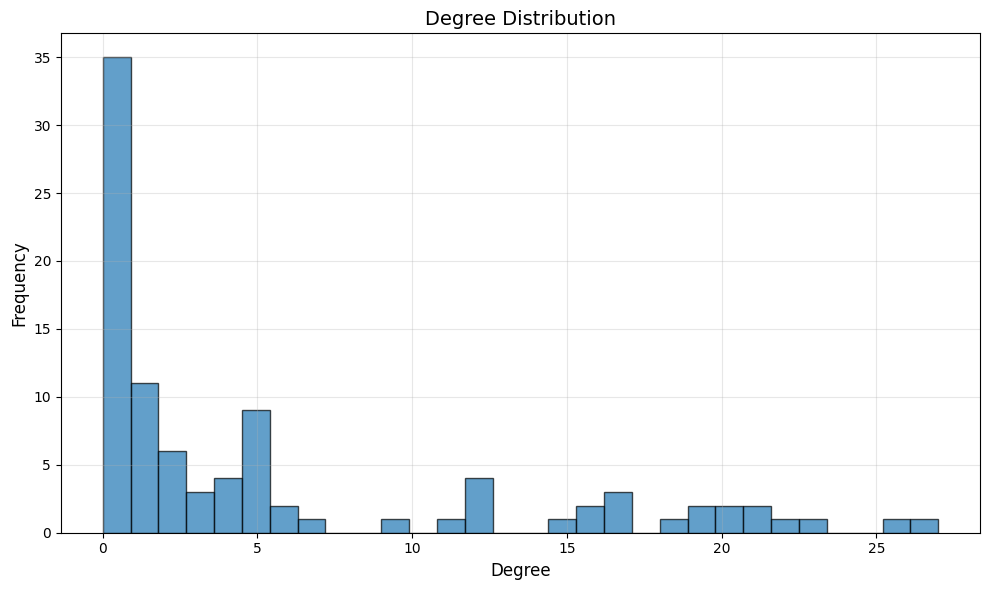

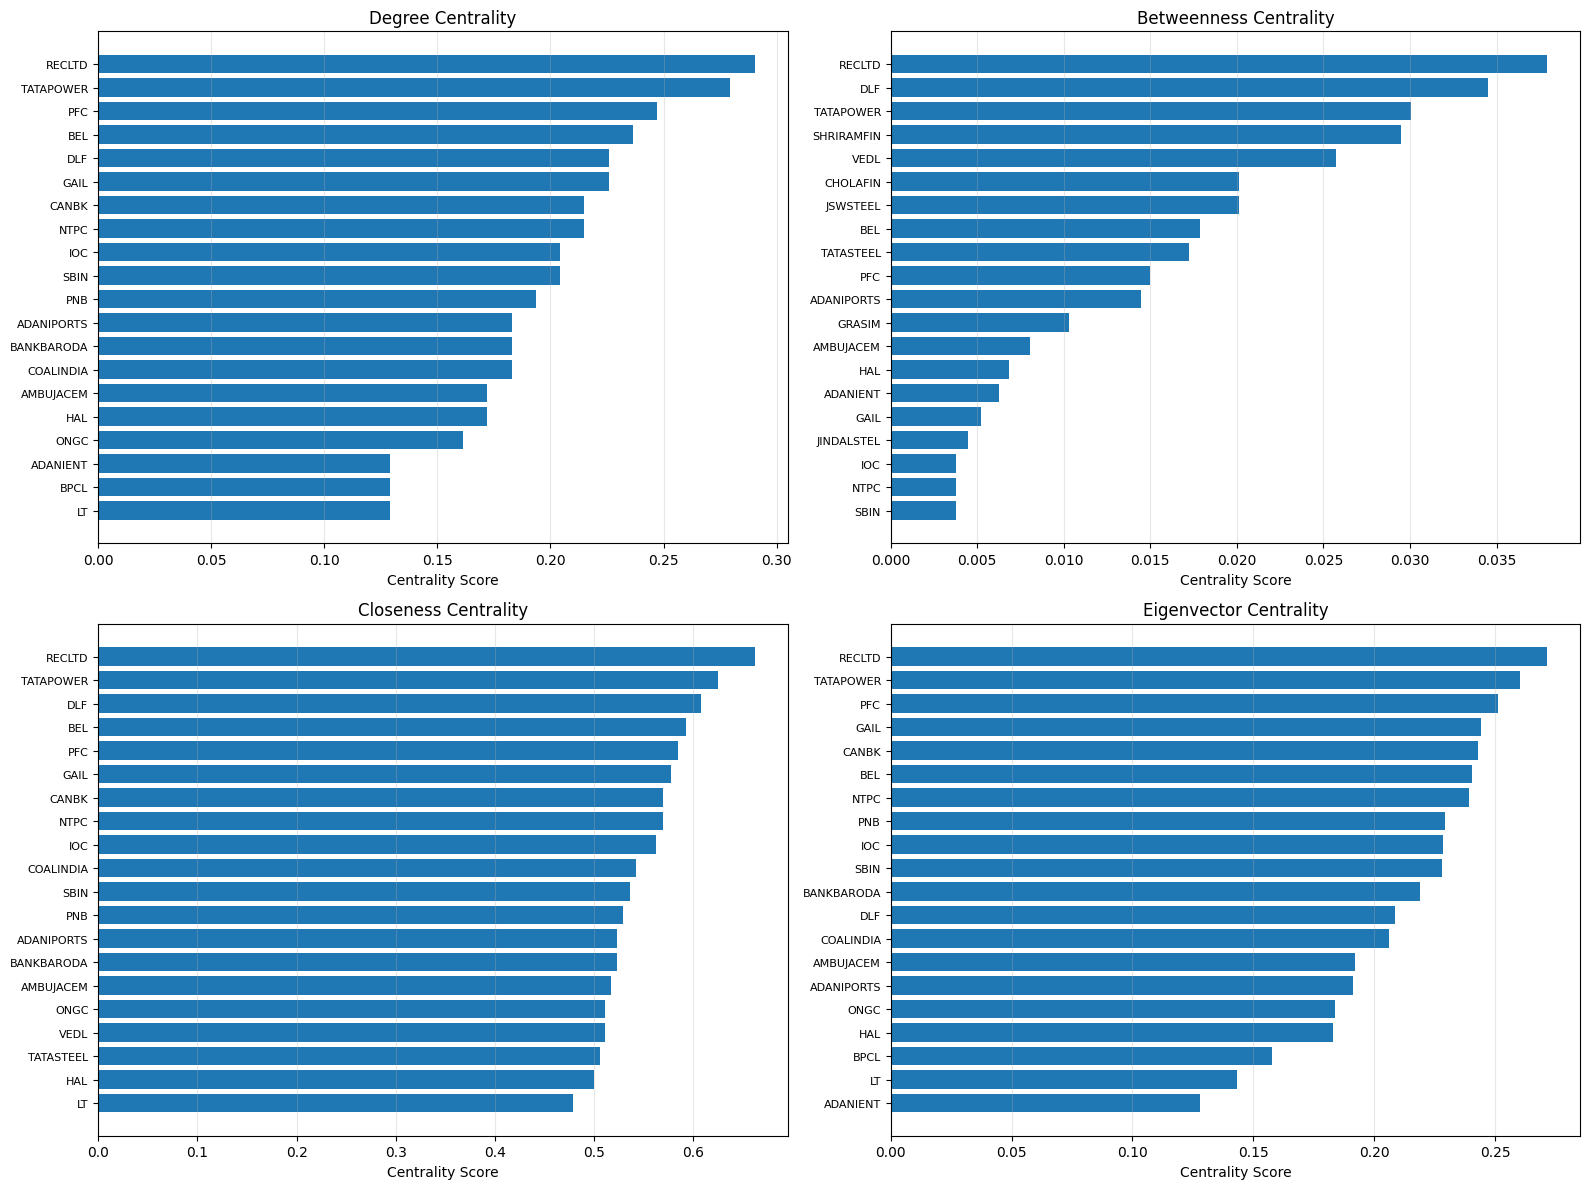

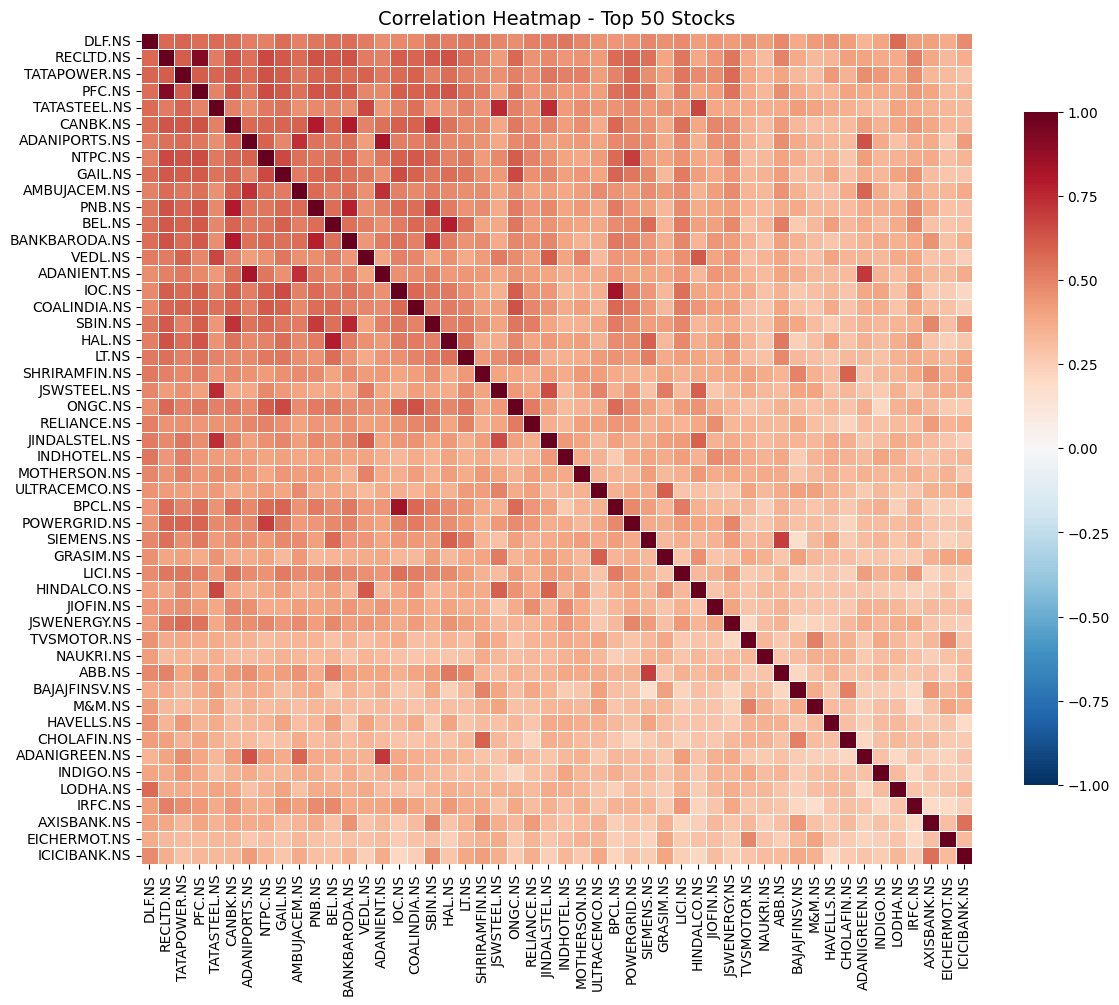

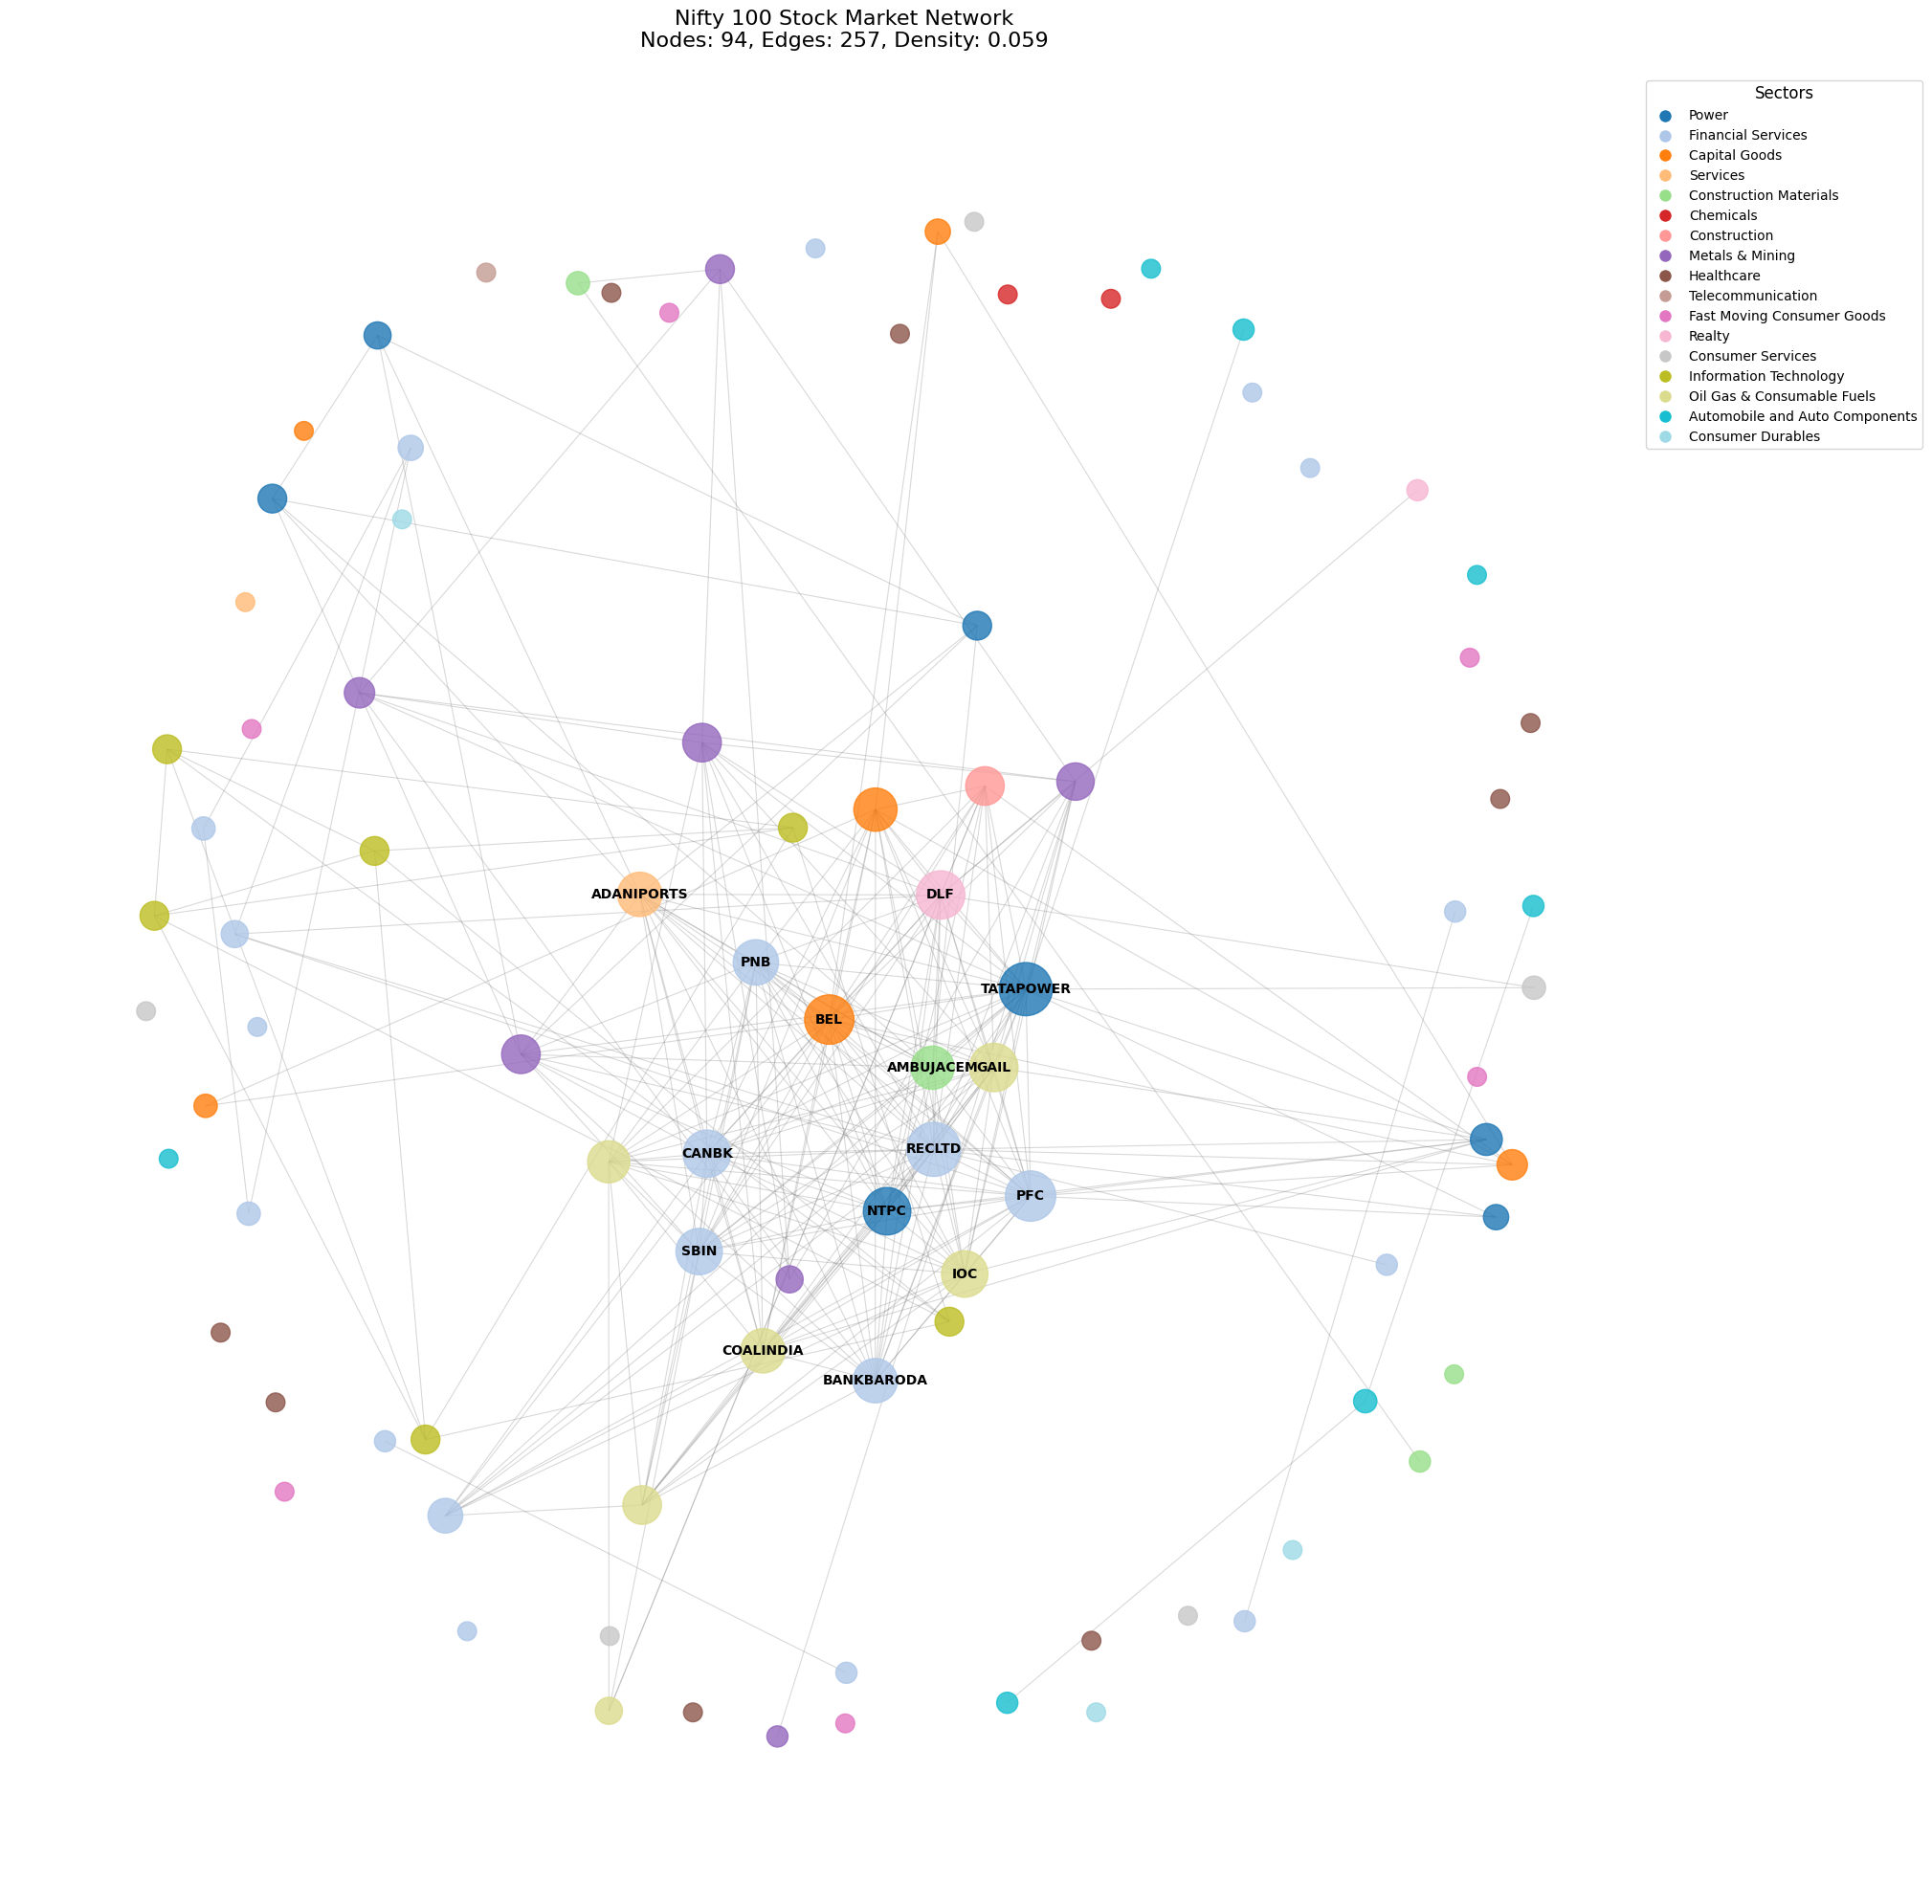


Top 10 Stocks by Degree Centrality:
RECLTD       | 0.2903 | Financial Services
TATAPOWER    | 0.2796 | Power
PFC          | 0.2473 | Financial Services
BEL          | 0.2366 | Capital Goods
DLF          | 0.2258 | Realty
GAIL         | 0.2258 | Oil Gas & Consumable Fuels
CANBK        | 0.2151 | Financial Services
NTPC         | 0.2151 | Power
IOC          | 0.2043 | Oil Gas & Consumable Fuels
SBIN         | 0.2043 | Financial Services


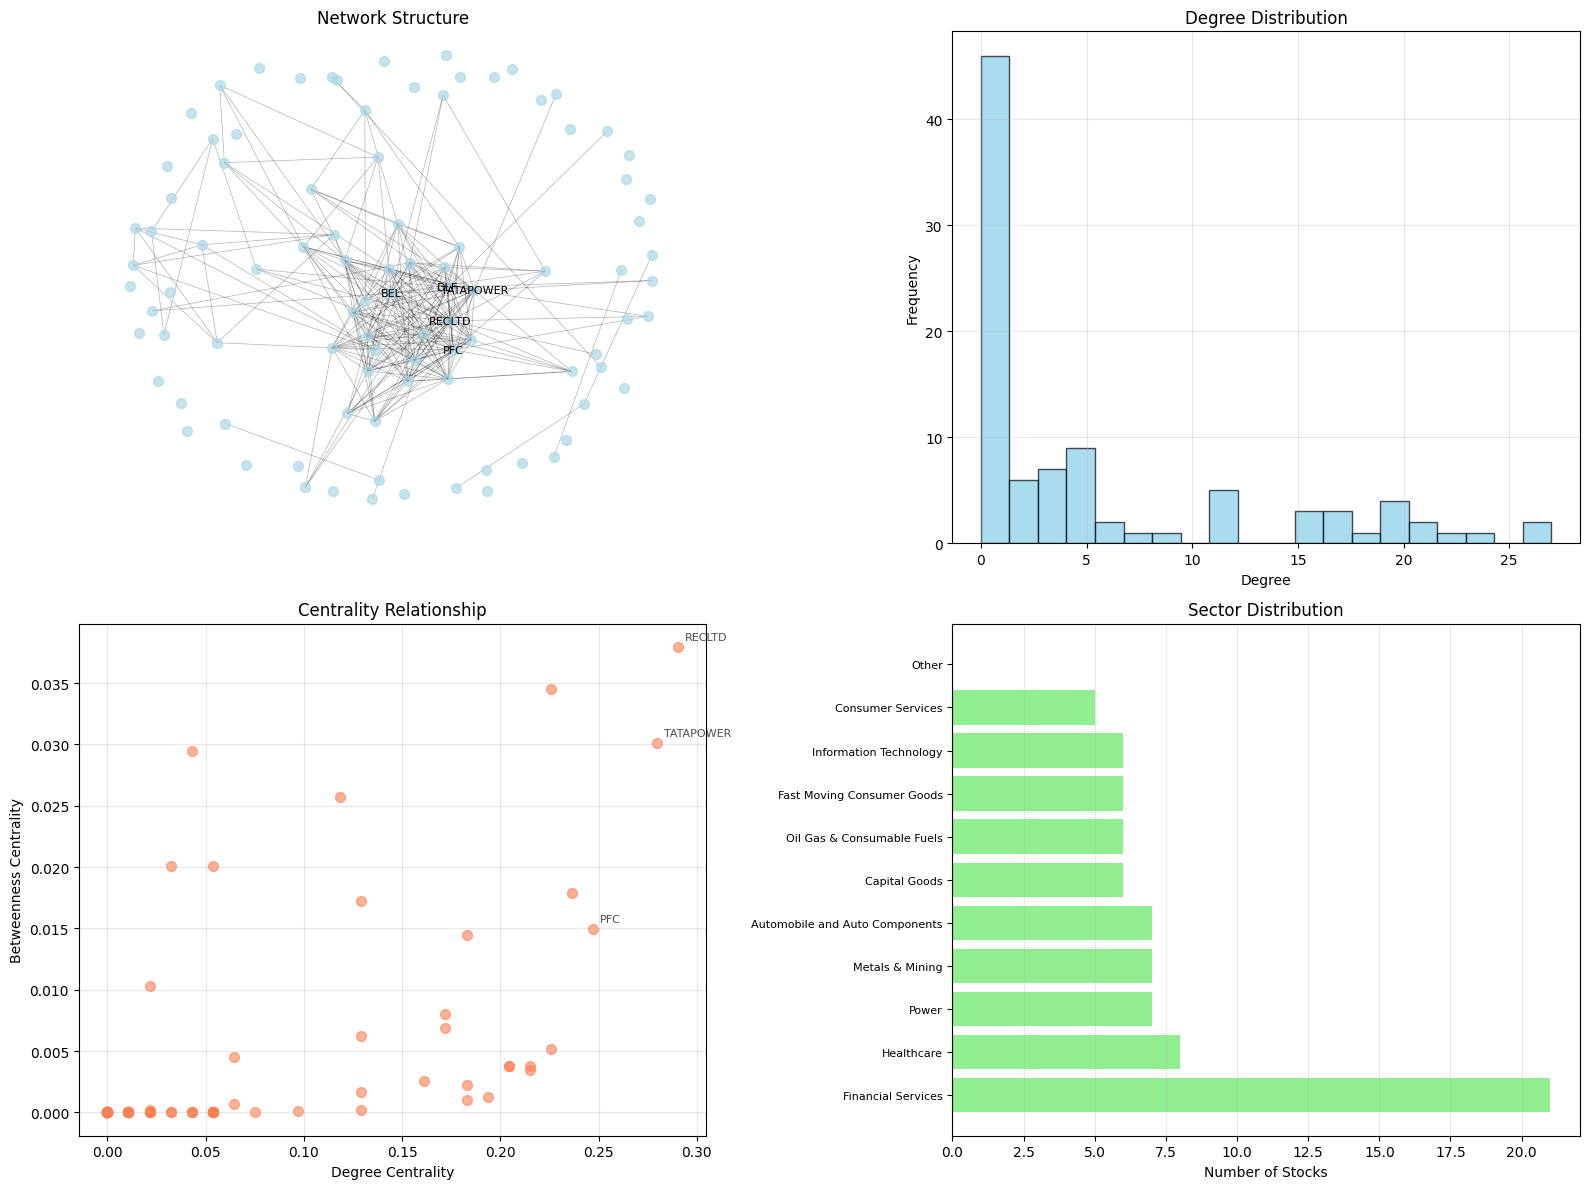


7. Conducting threshold study...

Creating correlation network from 493 days and 94 stocks...

Network Statistics (threshold=0.3):
Number of nodes: 94
Number of edges: 1480
Density: 0.3386

Creating correlation network from 493 days and 94 stocks...

Network Statistics (threshold=0.4):
Number of nodes: 94
Number of edges: 628
Density: 0.1437

Creating correlation network from 493 days and 94 stocks...

Network Statistics (threshold=0.5):
Number of nodes: 94
Number of edges: 257
Density: 0.0588

Creating correlation network from 493 days and 94 stocks...

Network Statistics (threshold=0.6):
Number of nodes: 94
Number of edges: 73
Density: 0.0167

Creating correlation network from 493 days and 94 stocks...

Network Statistics (threshold=0.7):
Number of nodes: 94
Number of edges: 19
Density: 0.0043

Creating correlation network from 493 days and 94 stocks...

Network Statistics (threshold=0.8):
Number of nodes: 94
Number of edges: 4
Density: 0.0009

Threshold Study Results:
 threshold  n

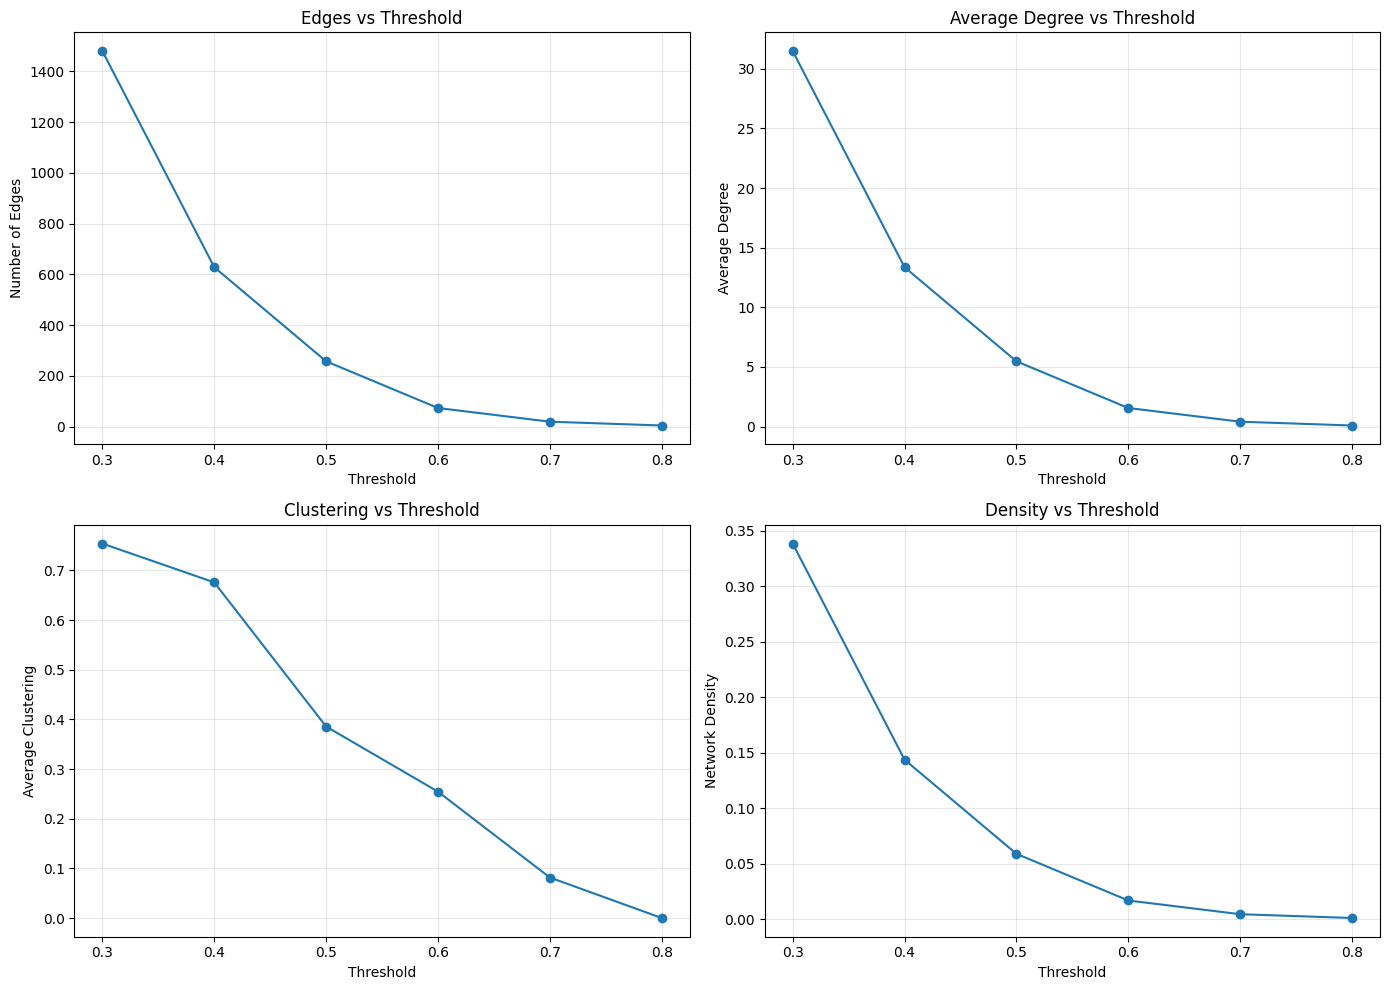


8. Creating MST network...

MST Network Statistics:
Number of nodes: 94
Number of edges: 93

Visualizing Minimum Spanning Tree...


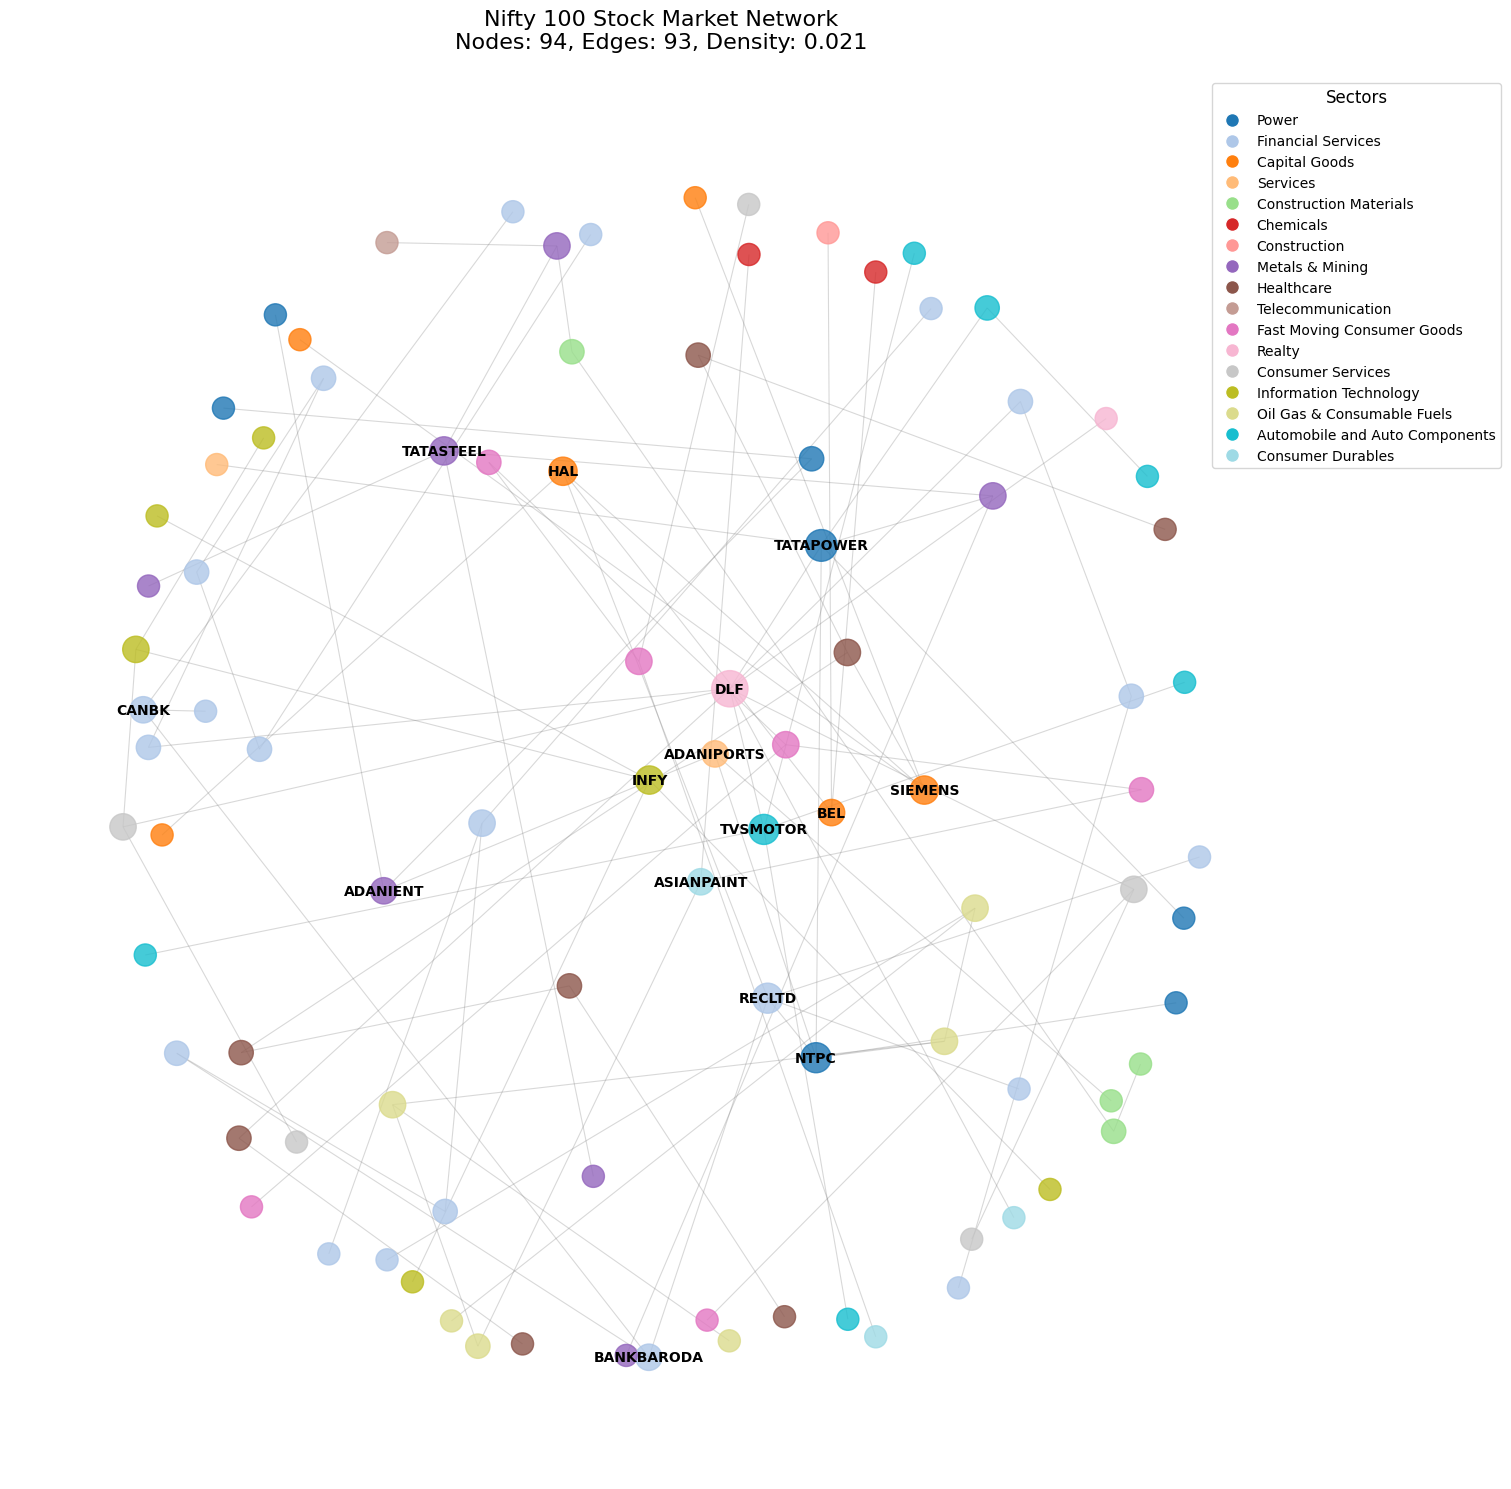


Top 10 Stocks by Degree Centrality:
DLF          | 0.0968 | Realty
TATAPOWER    | 0.0645 | Power
NTPC         | 0.0538 | Power
RECLTD       | 0.0538 | Financial Services
TVSMOTOR     | 0.0538 | Automobile and Auto Components
HAL          | 0.0430 | Capital Goods
INFY         | 0.0430 | Information Technology
SIEMENS      | 0.0430 | Capital Goods
TATASTEEL    | 0.0430 | Metals & Mining
ADANIENT     | 0.0323 | Metals & Mining

ANALYSIS COMPLETE!


In [7]:
"""
Stock Market Network Analysis - Indian Stock Market (Nifty 100)
ECS414/614 Network Science Assignment 2

This script creates and analyzes a stock correlation network from Indian stock market data.
"""

import pandas as pd
import numpy as np
import yfinance as yf
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import os
warnings.filterwarnings('ignore')

# ===========================
# 1. DATA COLLECTION
# ===========================

def load_stock_list(csv_file='ind_nifty100list.csv'):
    """Load list of stocks from CSV file"""
    try:
        df = pd.read_csv(csv_file)
        # Remove dummy stocks if any
        df = df[~df['Symbol'].str.contains('DUMMY', case=False, na=False)]
        # Add .NS suffix for NSE stocks
        df['Yahoo_Symbol'] = df['Symbol'] + '.NS'
        print(f"Loaded {len(df)} stocks from {csv_file}")
        return df
    except Exception as e:
        print(f"Error loading stock list: {e}")
        return None

def download_stock_data(symbols, start_date, end_date, filename='stock_data_nifty100.csv'):
    """
    Download historical stock data from Yahoo Finance

    Parameters:
    - symbols: list of stock symbols
    - start_date: start date for data
    - end_date: end date for data
    - filename: name to save the data
    """
    print(f"Downloading data for {len(symbols)} stocks from {start_date.date()} to {end_date.date()}...")

    # Download data
    data = yf.download(symbols, start=start_date, end=end_date, progress=True)

    # Handle different data structures
    if isinstance(data.columns, pd.MultiIndex):
        if 'Adj Close' in data.columns.get_level_values(0):
            prices = data['Adj Close']
        elif 'Close' in data.columns.get_level_values(0):
            prices = data['Close']
        else:
            prices = data.iloc[:, data.columns.get_level_values(0)[0]]
    else:
        if 'Adj Close' in data.columns:
            prices = data['Adj Close']
        elif 'Close' in data.columns:
            prices = data['Close']
        else:
            prices = data.iloc[:, 0]

    # Remove any columns with all NaN values
    prices = prices.dropna(axis=1, how='all')

    print(f"\nFinal prices data shape: {prices.shape}")

    # Save to CSV
    prices.to_csv(filename)
    print(f"Data saved to {filename}")

    return prices

def load_local_data(filename='stock_data_nifty100.csv'):
    """Load previously downloaded stock data"""
    try:
        prices = pd.read_csv(filename, index_col=0, parse_dates=True)
        print(f"Loaded local data: {prices.shape[0]} days, {prices.shape[1]} stocks")
        print(f"Date range: {prices.index.min()} to {prices.index.max()}")

        # Check for duplicate dates
        if prices.index.duplicated().any():
            prices = prices[~prices.index.duplicated(keep='first')]

        # Sort by date
        if not prices.index.is_monotonic_increasing:
            prices = prices.sort_index()

        # Remove all NaN rows
        prices = prices[~prices.isna().all(axis=1)]

        return prices
    except FileNotFoundError:
        print(f"Local file {filename} not found. Please download data first.")
        return None
    except Exception as e:
        print(f"Error loading local data: {e}")
        return None

# ===========================
# 2. NETWORK CREATION
# ===========================

def calculate_returns(prices, min_data_ratio=0.8):
    """
    Calculate daily returns from prices with robust handling of missing data

    Parameters:
    - prices: DataFrame of stock prices
    - min_data_ratio: minimum ratio of non-NaN data required for a stock to be included

    Returns:
    - returns: DataFrame of stock returns
    """
    print("\nCalculating returns...")

    # Ensure prices are sorted by date
    if not prices.index.is_monotonic_increasing:
        prices = prices.sort_index()

    # Calculate data availability for each stock
    data_availability = prices.count() / len(prices)
    print(f"\nData availability for top 10 stocks:")
    print(data_availability.sort_values(ascending=False).head(10))

    # Filter stocks with sufficient data
    valid_stocks = data_availability[data_availability >= min_data_ratio].index
    print(f"\nKeeping {len(valid_stocks)} stocks with at least {min_data_ratio*100}% data")

    # Keep only valid stocks
    prices_filtered = prices[valid_stocks]

    # Calculate percentage change
    returns = prices_filtered.pct_change()

    # Remove first row (which will be NaN)
    returns = returns.iloc[1:]

    print(f"\nReturns shape: {returns.shape}")
    print(f"Date range: {returns.index.min()} to {returns.index.max()}")

    # Check for remaining NaN values
    nan_counts = returns.isna().sum()
    if nan_counts.sum() > 0:
        print(f"\nWarning: Found {nan_counts.sum()} remaining NaN values in returns")
        print("Top 5 stocks with most NaNs:")
        print(nan_counts.sort_values(ascending=False).head())

        # Fill remaining NaNs with 0 (conservative approach)
        returns = returns.fillna(0)
        print("Filled remaining NaN values with 0")

    return returns

def create_correlation_network(returns, threshold=0.5):
    """
    Create a network based on correlation between stock returns

    Parameters:
    - returns: DataFrame of stock returns
    - threshold: correlation threshold for edge creation

    Returns:
    - G: NetworkX graph
    - corr_matrix: correlation matrix
    """
    if returns.empty or returns.shape[0] < 2 or returns.shape[1] < 2:
        print("Warning: Insufficient data for correlation analysis")
        return nx.Graph(), pd.DataFrame()

    print(f"\nCreating correlation network from {returns.shape[0]} days and {returns.shape[1]} stocks...")

    # Calculate correlation matrix
    corr_matrix = returns.corr()

    # Handle any remaining NaN values
    corr_matrix = corr_matrix.fillna(0)

    # Create graph
    G = nx.Graph()

    # Add nodes
    stocks = corr_matrix.columns
    for stock in stocks:
        G.add_node(stock)

    # Add edges based on correlation threshold
    edges_added = 0
    for i, stock1 in enumerate(stocks):
        for j, stock2 in enumerate(stocks):
            if i < j:  # Avoid duplicate edges
                corr_value = corr_matrix.loc[stock1, stock2]
                if abs(corr_value) >= threshold:
                    G.add_edge(stock1, stock2, weight=corr_value)
                    edges_added += 1

    print(f"\nNetwork Statistics (threshold={threshold}):")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {edges_added}")
    print(f"Density: {nx.density(G):.4f}")

    return G, corr_matrix

def create_mst_network(returns):
    """
    Create Minimum Spanning Tree network (distance-based)

    Parameters:
    - returns: DataFrame of stock returns

    Returns:
    - MST: NetworkX graph (Minimum Spanning Tree)
    """
    if returns.empty or returns.shape[0] < 2 or returns.shape[1] < 2:
        print("Warning: Insufficient data for MST analysis")
        return nx.Graph()

    corr_matrix = returns.corr()
    corr_matrix = corr_matrix.fillna(0)

    # Convert correlation to distance
    distance_matrix = np.sqrt(2 * (1 - corr_matrix))

    # Create complete graph with distances as weights
    G = nx.Graph()
    stocks = corr_matrix.columns

    for i, stock1 in enumerate(stocks):
        for j, stock2 in enumerate(stocks):
            if i < j:
                dist = distance_matrix.loc[stock1, stock2]
                G.add_edge(stock1, stock2, weight=dist)

    # Get MST
    MST = nx.minimum_spanning_tree(G)

    print(f"\nMST Network Statistics:")
    print(f"Number of nodes: {MST.number_of_nodes()}")
    print(f"Number of edges: {MST.number_of_edges()}")

    return MST

# ===========================
# 3. NETWORK ANALYSIS
# ===========================

def analyze_centrality(G):
    """Calculate various centrality measures"""

    if G.number_of_nodes() == 0:
        print("Warning: Empty graph - cannot calculate centrality")
        return {'degree': {}, 'betweenness': {}, 'closeness': {}, 'eigenvector': {}}

    centrality_measures = {}

    # Degree Centrality
    centrality_measures['degree'] = nx.degree_centrality(G)

    # Betweenness Centrality
    centrality_measures['betweenness'] = nx.betweenness_centrality(G)

    # Closeness Centrality
    if nx.is_connected(G):
        centrality_measures['closeness'] = nx.closeness_centrality(G)
    else:
        # For disconnected graphs, calculate for largest component
        largest_cc = max(nx.connected_components(G), key=len)
        G_largest = G.subgraph(largest_cc)
        centrality_measures['closeness'] = nx.closeness_centrality(G_largest)

    # Eigenvector Centrality
    try:
        centrality_measures['eigenvector'] = nx.eigenvector_centrality(G, max_iter=1000)
    except:
        print("Eigenvector centrality failed to converge")
        centrality_measures['eigenvector'] = {node: 0 for node in G.nodes()}

    return centrality_measures

def analyze_clustering(G):
    """Calculate clustering coefficients"""

    if G.number_of_nodes() == 0:
        print("Warning: Empty graph - cannot calculate clustering")
        return {}, 0, 0

    # Local clustering coefficient
    local_clustering = nx.clustering(G)

    # Average clustering coefficient
    avg_clustering = nx.average_clustering(G)

    # Global clustering coefficient (transitivity)
    global_clustering = nx.transitivity(G)

    print(f"\nClustering Analysis:")
    print(f"Average Clustering Coefficient: {avg_clustering:.4f}")
    print(f"Global Clustering Coefficient: {global_clustering:.4f}")

    return local_clustering, avg_clustering, global_clustering

def analyze_degree_distribution(G):
    """Analyze degree distribution"""

    if G.number_of_nodes() == 0:
        print("Warning: Empty graph - cannot analyze degree distribution")
        return [], pd.Series()

    degrees = [G.degree(n) for n in G.nodes()]
    degree_counts = pd.Series(degrees).value_counts().sort_index()

    print(f"\nDegree Distribution:")
    print(f"Average Degree: {np.mean(degrees):.2f}")
    print(f"Max Degree: {np.max(degrees)}")
    print(f"Min Degree: {np.min(degrees)}")

    return degrees, degree_counts

def analyze_assortativity(G):
    """Calculate assortativity coefficient"""

    if G.number_of_nodes() == 0:
        print("Warning: Empty graph - cannot calculate assortativity")
        return None

    try:
        assortativity = nx.degree_assortativity_coefficient(G)
        print(f"\nDegree Assortativity: {assortativity:.4f}")
        return assortativity
    except:
        print("Could not calculate assortativity")
        return None

def analyze_components(G):
    """Analyze connected components"""

    if G.number_of_nodes() == 0:
        print("Warning: Empty graph - no components")
        return 0, 0

    if nx.is_connected(G):
        print("\nNetwork is fully connected")
        num_components = 1
        largest_component_size = G.number_of_nodes()
    else:
        components = list(nx.connected_components(G))
        num_components = len(components)
        largest_component_size = len(max(components, key=len))

        print(f"\nConnected Components: {num_components}")
        print(f"Largest Component Size: {largest_component_size}")

    return num_components, largest_component_size

# ===========================
# 4. VISUALIZATION
# ===========================

def plot_network(G, stock_df, layout='spring', figsize=(20, 20), save_file='stock_network.png'):
    """
    Visualize stock market network with sector coloring and node sizing

    Parameters:
    - G: NetworkX graph
    - stock_df: DataFrame with stock information (including sectors)
    - layout: layout algorithm ('spring', 'kamada_kawai', or 'circular')
    - figsize: figure size tuple
    - save_file: filename to save plot
    """
    if G.number_of_nodes() == 0:
        print("Empty network - cannot visualize")
        return

    # Create a mapping from symbol to sector
    symbol_to_sector = {}
    for _, row in stock_df.iterrows():
        symbol = row['Symbol'] + '.NS'
        sector = row['Industry']
        symbol_to_sector[symbol] = sector

    # Calculate centrality measures for node sizing
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)

    # Create figure
    plt.figure(figsize=figsize)

    # Choose layout
    if layout == 'spring':
        pos = nx.spring_layout(G, k=1, iterations=50, seed=42)
    elif layout == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(G)
    else:
        pos = nx.circular_layout(G)

    # Get unique sectors for coloring
    sectors = list(set([symbol_to_sector.get(node, 'Unknown') for node in G.nodes()]))

    # Create color map for sectors
    if len(sectors) <= 20:
        colors = plt.cm.tab20(np.linspace(0, 1, len(sectors)))
    else:
        colors = plt.cm.tab20b(np.linspace(0, 1, len(sectors)))

    sector_colors = {sector: colors[i] for i, sector in enumerate(sectors)}

    # Map nodes to colors based on sector
    node_colors = [sector_colors.get(symbol_to_sector.get(node, 'Unknown'), 'gray') for node in G.nodes()]

    # Scale node sizes based on degree centrality
    node_sizes = [degree_centrality[node] * 5000 + 200 for node in G.nodes()]

    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.8, edge_color='gray')

    # Draw nodes
    nodes = nx.draw_networkx_nodes(G, pos,
                                   node_size=node_sizes,
                                   node_color=node_colors,
                                   alpha=0.8)

    # Draw labels for important nodes (top 15 by degree centrality)
    important_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:15]
    labels = {node: node.replace('.NS', '') for node, _ in important_nodes}
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight='bold')

    # Create legend for sectors
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                 markerfacecolor=sector_colors[sector],
                                 markersize=10, label=sector)
                     for sector in sectors]

    plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1),
               title='Sectors', title_fontsize=12)

    # Add title with network statistics
    plt.title(f'Nifty 100 Stock Market Network\n'
              f'Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}, '
              f'Density: {nx.density(G):.3f}',
              fontsize=16, pad=20)

    plt.axis('off')
    plt.tight_layout()
    plt.savefig(save_file, dpi=300, bbox_inches='tight')
    plt.show()

    # Print top stocks by centrality
    print("\nTop 10 Stocks by Degree Centrality:")
    for node, centrality in sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]:
        sector = symbol_to_sector.get(node, 'Unknown')
        print(f"{node.replace('.NS', ''):12} | {centrality:.4f} | {sector}")

def plot_network_alternative(G, stock_df, figsize=(16, 12)):
    """
    Alternative visualization showing multiple network aspects

    Parameters:
    - G: NetworkX graph
    - stock_df: DataFrame with stock information
    - figsize: figure size tuple
    """
    if G.number_of_nodes() == 0:
        print("Empty network - cannot visualize")
        return

    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)

    # Create symbol to sector mapping
    symbol_to_sector = {}
    for _, row in stock_df.iterrows():
        symbol = row['Symbol'] + '.NS'
        sector = row['Industry']
        symbol_to_sector[symbol] = sector

    # 1. Network visualization (top-left)
    ax1 = axes[0, 0]
    pos = nx.spring_layout(G, k=0.8, iterations=50, seed=42)

    # Simple visualization without sector colors
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5, ax=ax1)
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color='lightblue', alpha=0.7, ax=ax1)

    # Label top 5 nodes
    degree_centrality = nx.degree_centrality(G)
    top_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
    labels = {node: node.replace('.NS', '') for node, _ in top_nodes}
    nx.draw_networkx_labels(G, pos, labels, font_size=8, ax=ax1)

    ax1.set_title('Network Structure', fontsize=12)
    ax1.axis('off')

    # 2. Degree distribution (top-right)
    ax2 = axes[0, 1]
    degrees = [G.degree(n) for n in G.nodes()]
    ax2.hist(degrees, bins=20, edgecolor='black', alpha=0.7, color='skyblue')
    ax2.set_xlabel('Degree', fontsize=10)
    ax2.set_ylabel('Frequency', fontsize=10)
    ax2.set_title('Degree Distribution', fontsize=12)
    ax2.grid(True, alpha=0.3)

    # 3. Centrality scatter plot (bottom-left)
    ax3 = axes[1, 0]
    degree_cent = nx.degree_centrality(G)
    betweenness_cent = nx.betweenness_centrality(G)

    nodes = list(degree_cent.keys())
    x = [degree_cent[node] for node in nodes]
    y = [betweenness_cent[node] for node in nodes]

    ax3.scatter(x, y, alpha=0.6, s=50, c='coral')
    ax3.set_xlabel('Degree Centrality', fontsize=10)
    ax3.set_ylabel('Betweenness Centrality', fontsize=10)
    ax3.set_title('Centrality Relationship', fontsize=12)
    ax3.grid(True, alpha=0.3)

    # Label top nodes in scatter plot
    for node, _ in top_nodes[:3]:
        ax3.annotate(node.replace('.NS', ''),
                    (degree_cent[node], betweenness_cent[node]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=0.7)

    # 4. Sector distribution (bottom-right)
    ax4 = axes[1, 1]
    sector_counts = {}
    for node in G.nodes():
        sector = symbol_to_sector.get(node, 'Unknown')
        sector_counts[sector] = sector_counts.get(sector, 0) + 1

    sectors = list(sector_counts.keys())
    counts = list(sector_counts.values())

    # Only show top 10 sectors
    if len(sectors) > 10:
        sorted_sectors = sorted(zip(sectors, counts), key=lambda x: x[1], reverse=True)
        sectors, counts = zip(*sorted_sectors[:10])
        sectors = list(sectors) + ['Other']
        counts = list(counts) + [sum(counts[10:])]

    ax4.barh(range(len(sectors)), counts, color='lightgreen')
    ax4.set_yticks(range(len(sectors)))
    ax4.set_yticklabels(sectors, fontsize=8)
    ax4.set_xlabel('Number of Stocks', fontsize=10)
    ax4.set_title('Sector Distribution', fontsize=12)
    ax4.grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.savefig('network_analysis_overview.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_degree_distribution(degrees):
    """Plot degree distribution"""

    if not degrees:
        print("No degrees to plot")
        return

    plt.figure(figsize=(10, 6))
    plt.hist(degrees, bins=30, edgecolor='black', alpha=0.7)
    plt.xlabel('Degree', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Degree Distribution', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('degree_distribution_nifty100.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_centrality_comparison(centrality_measures, top_n=20):
    """Plot top nodes by different centrality measures"""

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    measures = ['degree', 'betweenness', 'closeness', 'eigenvector']
    titles = ['Degree Centrality', 'Betweenness Centrality',
              'Closeness Centrality', 'Eigenvector Centrality']

    for idx, (measure, title) in enumerate(zip(measures, titles)):
        ax = axes[idx // 2, idx % 2]

        if centrality_measures[measure] and len(centrality_measures[measure]) > 0:
            # Get top N nodes
            sorted_nodes = sorted(centrality_measures[measure].items(),
                                 key=lambda x: x[1], reverse=True)[:top_n]
            nodes, values = zip(*sorted_nodes)

            # Clean node names (remove .NS)
            clean_nodes = [n.replace('.NS', '') for n in nodes]

            ax.barh(range(len(nodes)), values)
            ax.set_yticks(range(len(nodes)))
            ax.set_yticklabels(clean_nodes, fontsize=8)
            ax.invert_yaxis()
            ax.set_xlabel('Centrality Score', fontsize=10)
            ax.set_title(title, fontsize=12)
            ax.grid(True, alpha=0.3, axis='x')
        else:
            ax.text(0.5, 0.5, f'No data for {title}',
                   ha='center', va='center', transform=ax.transAxes)

    plt.tight_layout()
    plt.savefig('centrality_comparison_nifty100.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_correlation_heatmap(corr_matrix, top_n=50):
    """Plot correlation heatmap for top N stocks"""

    if corr_matrix.empty:
        print("No correlation matrix to plot")
        return

    # Select top N stocks by average correlation
    avg_corr = corr_matrix.mean().sort_values(ascending=False)
    top_stocks = avg_corr.head(min(top_n, len(avg_corr))).index

    # Create subset correlation matrix
    corr_subset = corr_matrix.loc[top_stocks, top_stocks]

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_subset, cmap='RdBu_r', center=0, vmin=-1, vmax=1,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    plt.title(f'Correlation Heatmap - Top {len(top_stocks)} Stocks', fontsize=14)
    plt.tight_layout()
    plt.savefig('correlation_heatmap_nifty100.png', dpi=300, bbox_inches='tight')
    plt.show()

# ===========================
# 5. PARAMETER STUDY
# ===========================

def threshold_study(returns, thresholds=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8]):
    """Study how network properties change with correlation threshold"""

    if returns.empty:
        print("No returns data for threshold study")
        return pd.DataFrame()

    results = []

    for threshold in thresholds:
        G, _ = create_correlation_network(returns, threshold=threshold)

        if G.number_of_nodes() == 0:
            continue

        degrees = [G.degree(n) for n in G.nodes()]
        avg_clustering = nx.average_clustering(G)

        if nx.is_connected(G):
            num_components = 1
            largest_component_size = G.number_of_nodes()
            diameter = nx.diameter(G)
            avg_path_length = nx.average_shortest_path_length(G)
        else:
            components = list(nx.connected_components(G))
            num_components = len(components)
            largest_component_size = len(max(components, key=len))
            largest_cc = max(components, key=len)
            G_largest = G.subgraph(largest_cc)
            diameter = nx.diameter(G_largest)
            avg_path_length = nx.average_shortest_path_length(G_largest)

        results.append({
            'threshold': threshold,
            'num_edges': G.number_of_edges(),
            'density': nx.density(G),
            'avg_degree': np.mean(degrees),
            'avg_clustering': avg_clustering,
            'num_components': num_components,
            'largest_component_size': largest_component_size,
            'diameter': diameter,
            'avg_path_length': avg_path_length
        })

    results_df = pd.DataFrame(results)
    print("\nThreshold Study Results:")
    print(results_df.to_string(index=False))

    # Plot results
    if len(results_df) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        axes[0, 0].plot(results_df['threshold'], results_df['num_edges'], 'o-')
        axes[0, 0].set_xlabel('Threshold')
        axes[0, 0].set_ylabel('Number of Edges')
        axes[0, 0].set_title('Edges vs Threshold')
        axes[0, 0].grid(True, alpha=0.3)

        axes[0, 1].plot(results_df['threshold'], results_df['avg_degree'], 'o-')
        axes[0, 1].set_xlabel('Threshold')
        axes[0, 1].set_ylabel('Average Degree')
        axes[0, 1].set_title('Average Degree vs Threshold')
        axes[0, 1].grid(True, alpha=0.3)

        axes[1, 0].plot(results_df['threshold'], results_df['avg_clustering'], 'o-')
        axes[1, 0].set_xlabel('Threshold')
        axes[1, 0].set_ylabel('Average Clustering')
        axes[1, 0].set_title('Clustering vs Threshold')
        axes[1, 0].grid(True, alpha=0.3)

        axes[1, 1].plot(results_df['threshold'], results_df['density'], 'o-')
        axes[1, 1].set_xlabel('Threshold')
        axes[1, 1].set_ylabel('Network Density')
        axes[1, 1].set_title('Density vs Threshold')
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('threshold_study_nifty100.png', dpi=300, bbox_inches='tight')
        plt.show()

    return results_df

# ===========================
# 6. MAIN EXECUTION
# ===========================

def main():
    """Main execution function"""

    print("=" * 60)
    print("STOCK MARKET NETWORK ANALYSIS - NIFTY 100")
    print("=" * 60)

    # Step 1: Load stock list
    print("\n1. Loading stock list...")
    stock_df = load_stock_list('ind_nifty100list.csv')
    if stock_df is None:
        print("Failed to load stock list. Exiting.")
        return None, None, None, None, None

    # Step 2: Download or load data
    symbols = stock_df['Yahoo_Symbol'].tolist()
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365)  # 1 year of data as requested

    print("\n2. Data Collection...")

    # Check if local data exists
    if os.path.exists('stock_data_nifty100.csv'):
        print("Loading local data...")
        prices = load_local_data('stock_data_nifty100.csv')
    else:
        print("Local data not found. Downloading from Yahoo Finance...")
        prices = download_stock_data(symbols, start_date, end_date)

    if prices is None or prices.empty:
        print("No price data available. Exiting.")
        return None, None, None, None, None

    # Step 3: Calculate returns
    returns = calculate_returns(prices, min_data_ratio=0.8)

    if returns.empty:
        print("No returns data available. Exiting.")
        return None, None, None, None, None

    # Step 4: Create network
    print("\n4. Creating network...")
    threshold = 0.5
    G, corr_matrix = create_correlation_network(returns, threshold=threshold)

    if G.number_of_nodes() == 0:
        print("Network has no nodes. Try lowering the threshold.")
        return None, None, None, None, None

    # Step 5: Network Analysis
    print("\n5. Network Analysis...")

    print("\n--- Centrality Analysis ---")
    centrality_measures = analyze_centrality(G)

    print("\n--- Clustering Analysis ---")
    local_clustering, avg_clustering, global_clustering = analyze_clustering(G)

    print("\n--- Degree Distribution ---")
    degrees, degree_counts = analyze_degree_distribution(G)

    print("\n--- Assortativity ---")
    assortativity = analyze_assortativity(G)

    print("\n--- Components ---")
    num_components, largest_component_size = analyze_components(G)

    # Step 6: Visualization
    print("\n6. Creating network visualizations...")
    plot_degree_distribution(degrees)
    plot_centrality_comparison(centrality_measures)
    plot_correlation_heatmap(corr_matrix)

    # Main network visualization
    plot_network(G, stock_df, layout='spring', figsize=(20, 20))

    # Alternative overview visualization
    plot_network_alternative(G, stock_df, figsize=(16, 12))

    # Step 7: Parameter Study
    print("\n7. Conducting threshold study...")
    threshold_results = threshold_study(returns)

    # Step 8: MST Network (Alternative approach)
    print("\n8. Creating MST network...")
    MST = create_mst_network(returns)

    # Visualize MST if it has nodes
    if MST.number_of_nodes() > 0:
        print("\nVisualizing Minimum Spanning Tree...")
        plot_network(MST, stock_df, layout='spring',
                    figsize=(15, 15),
                    save_file='stock_network_mst.png')

    print("\n" + "=" * 60)
    print("ANALYSIS COMPLETE!")
    print("=" * 60)

    return G, corr_matrix, centrality_measures, returns, stock_df

if __name__ == "__main__":
    G, corr_matrix, centrality_measures, returns, stock_df = main()


6. Performing comprehensive network analysis...
COMPREHENSIVE NETWORK ANALYSIS

1. LOCAL CLUSTERING COEFFICIENT ANALYSIS
----------------------------------------
Average Clustering Coefficient: 0.3857
Global Clustering Coefficient (Transitivity): 0.6556

Top 15 Stocks by Local Clustering Coefficient:
     Stock  Clustering_Coefficient  Degree
       ABB                     1.0       3
ADANIPOWER                     1.0       4
BAJAJFINSV                     1.0       2
BAJFINANCE                     1.0       2
       TCS                     1.0       5
     TECHM                     1.0       5
   MAZDOCK                     1.0       2
 POWERGRID                     1.0       7
      LTIM                     1.0       5
 JSWENERGY                     1.0       3
      INFY                     1.0       5
  INDHOTEL                     1.0       2
  HINDALCO                     1.0       4
   HCLTECH                     1.0       5
     WIPRO                     1.0       5

Bottom 1

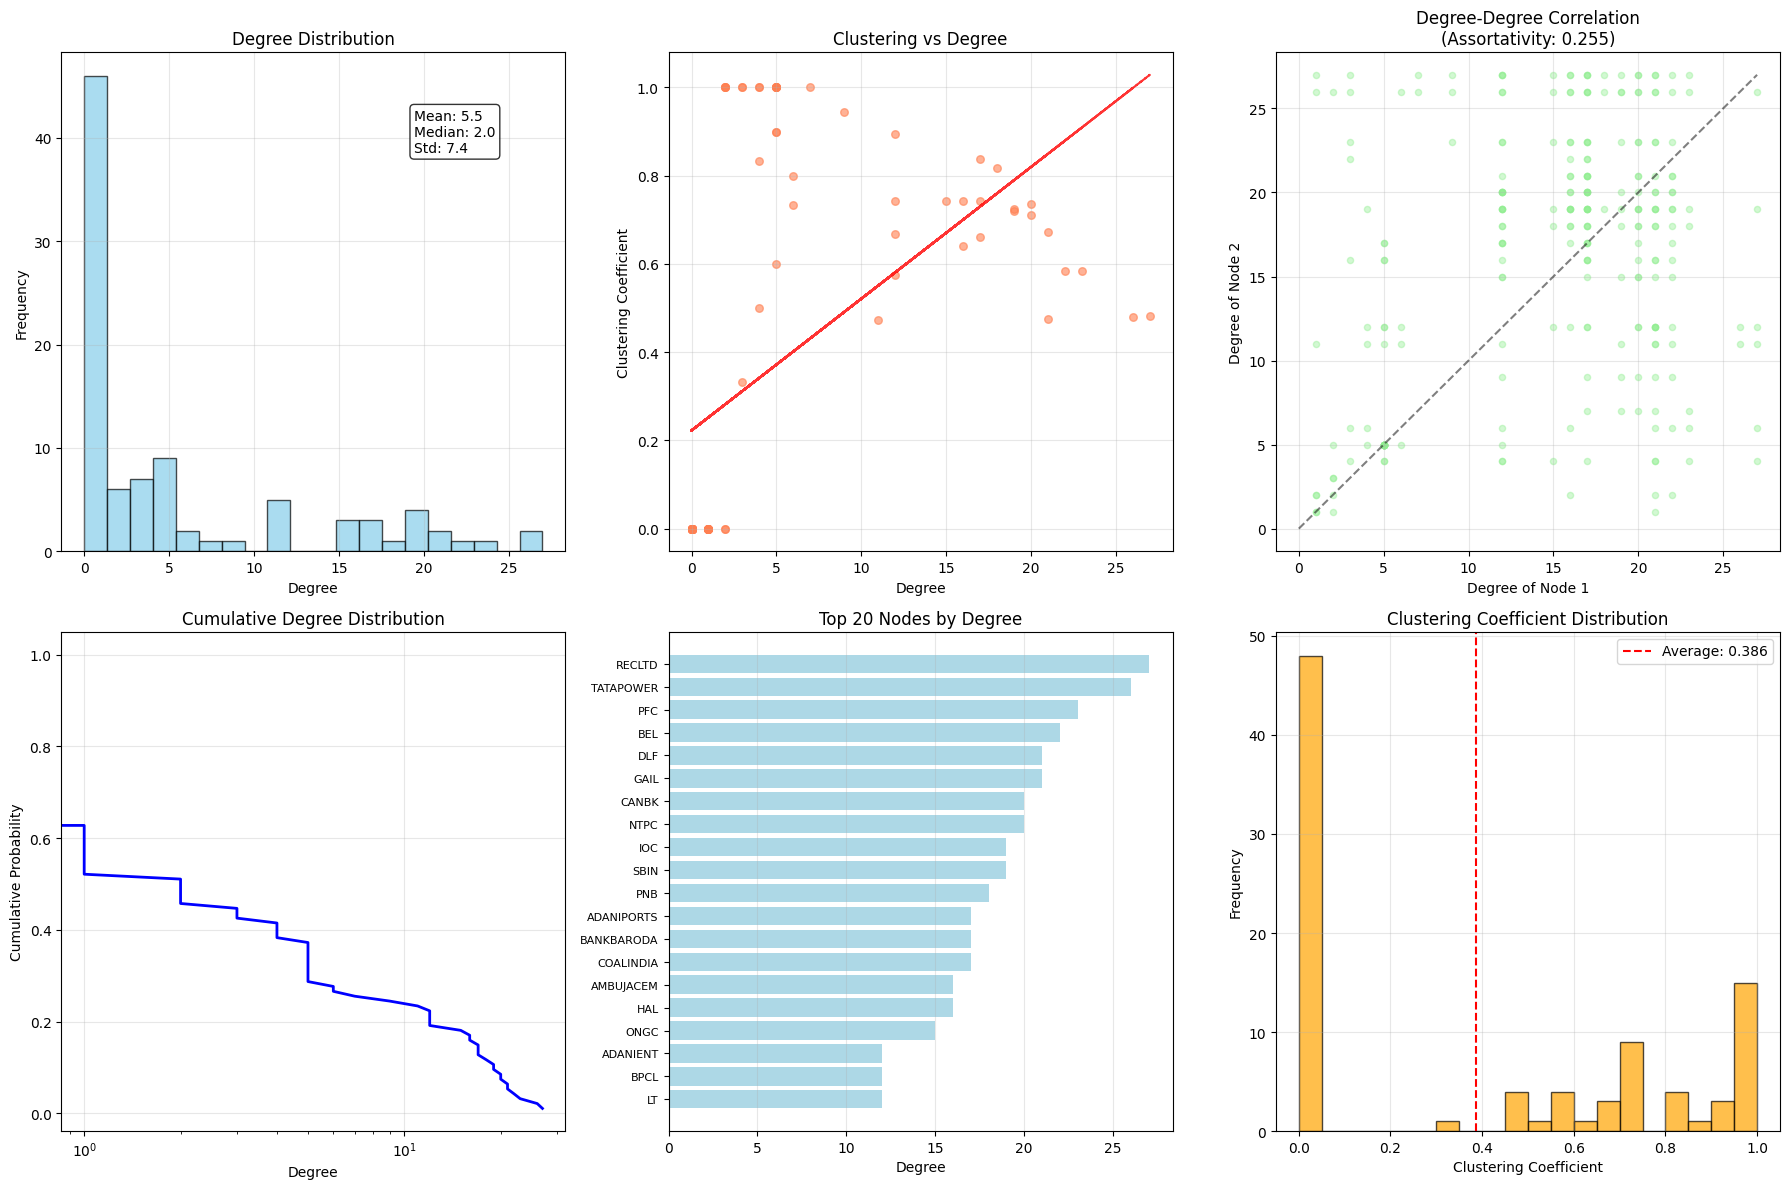


NETWORK SUMMARY REPORT
                        Metric              Value
                   Total Nodes                 94
                   Total Edges                257
               Network Density             0.0588
                Average Degree               5.47
                Maximum Degree                 27
                Minimum Degree                  0
Average Clustering Coefficient             0.3857
 Global Clustering Coefficient             0.6556
          Degree Assortativity             0.2546
Number of Connected Components                 40
           Average Path Length N/A (disconnected)
              Network Diameter N/A (disconnected)


In [8]:
def comprehensive_network_analysis(G, stock_df, returns):
    """
    Perform comprehensive network analysis including:
    - Local clustering coefficients
    - Similarity scores (Jaccard similarity)
    - Assortative mixing by degree
    - Detailed degree distribution analysis
    """

    if G.number_of_nodes() == 0:
        print("Empty network - cannot perform analysis")
        return None

    print("=" * 60)
    print("COMPREHENSIVE NETWORK ANALYSIS")
    print("=" * 60)

    # ===========================
    # 1. LOCAL CLUSTERING COEFFICIENTS
    # ===========================
    print("\n1. LOCAL CLUSTERING COEFFICIENT ANALYSIS")
    print("-" * 40)

    local_clustering = nx.clustering(G)
    avg_clustering = nx.average_clustering(G)

    # Create DataFrame for analysis
    clustering_df = pd.DataFrame({
        'Stock': [node.replace('.NS', '') for node in local_clustering.keys()],
        'Clustering_Coefficient': list(local_clustering.values()),
        'Degree': [G.degree(node) for node in local_clustering.keys()]
    })

    # Sort by clustering coefficient
    clustering_df = clustering_df.sort_values('Clustering_Coefficient', ascending=False)

    print(f"Average Clustering Coefficient: {avg_clustering:.4f}")
    print(f"Global Clustering Coefficient (Transitivity): {nx.transitivity(G):.4f}")
    print("\nTop 15 Stocks by Local Clustering Coefficient:")
    print(clustering_df.head(15).to_string(index=False))

    print("\nBottom 10 Stocks by Local Clustering Coefficient:")
    print(clustering_df.tail(10).to_string(index=False))

    # ===========================
    # 2. SIMILARITY SCORES (JACCARD SIMILARITY)
    # ===========================
    print("\n2. NODE SIMILARITY ANALYSIS (Jaccard Index)")
    print("-" * 40)

    # Calculate Jaccard similarity for all node pairs
    jaccard_similarities = {}

    for node1 in G.nodes():
        for node2 in G.nodes():
            if node1 < node2:  # Avoid duplicate pairs
                # Get neighbors
                neighbors1 = set(G.neighbors(node1))
                neighbors2 = set(G.neighbors(node2))

                # Calculate Jaccard similarity
                intersection = len(neighbors1.intersection(neighbors2))
                union = len(neighbors1.union(neighbors2))

                if union > 0:
                    similarity = intersection / union
                    jaccard_similarities[(node1, node2)] = similarity

    # Get top similar pairs
    top_similar_pairs = sorted(jaccard_similarities.items(), key=lambda x: x[1], reverse=True)[:20]

    print("Top 20 Most Similar Stock Pairs (Jaccard Index):")
    for (stock1, stock2), similarity in top_similar_pairs:
        stock1_clean = stock1.replace('.NS', '')
        stock2_clean = stock2.replace('.NS', '')
        print(f"{stock1_clean:12} - {stock2_clean:12}: {similarity:.4f}")

    # ===========================
    # 3. ASSORTATIVE MIXING BY DEGREE
    # ===========================
    print("\n3. ASSORTATIVE MIXING ANALYSIS")
    print("-" * 40)

    # Degree assortativity
    degree_assortativity = nx.degree_assortativity_coefficient(G)
    print(f"Degree Assortativity Coefficient: {degree_assortativity:.4f}")

    if degree_assortativity > 0.1:
        print("Network shows ASSORTATIVE mixing (high-degree nodes connect to high-degree nodes)")
    elif degree_assortativity < -0.1:
        print("Network shows DISASSORTATIVE mixing (high-degree nodes connect to low-degree nodes)")
    else:
        print("Network shows NEUTRAL mixing (no clear preference in connections)")

    # Calculate degree correlation matrix
    degrees = dict(G.degree())
    degree_correlations = []

    for edge in G.edges():
        degree1 = degrees[edge[0]]
        degree2 = degrees[edge[1]]
        degree_correlations.append((degree1, degree2))

    if degree_correlations:
        degree1_list, degree2_list = zip(*degree_correlations)
        correlation = np.corrcoef(degree1_list, degree2_list)[0, 1]
        print(f"Degree-Degree Correlation: {correlation:.4f}")

    # ===========================
    # 4. DETAILED DEGREE DISTRIBUTION ANALYSIS
    # ===========================
    print("\n4. DEGREE DISTRIBUTION ANALYSIS")
    print("-" * 40)

    degrees = [G.degree(n) for n in G.nodes()]
    degree_counts = pd.Series(degrees).value_counts().sort_index()

    print(f"Total Nodes: {G.number_of_nodes()}")
    print(f"Total Edges: {G.number_of_edges()}")
    print(f"Average Degree: {np.mean(degrees):.2f}")
    print(f"Median Degree: {np.median(degrees):.2f}")
    print(f"Standard Deviation: {np.std(degrees):.2f}")
    print(f"Minimum Degree: {np.min(degrees)}")
    print(f"Maximum Degree: {np.max(degrees)}")

    # Degree distribution statistics
    print("\nDegree Distribution:")
    print("Degree | Count | Percentage")
    print("-" * 30)
    for degree, count in degree_counts.items():
        percentage = (count / len(degrees)) * 100
        print(f"{degree:6} | {count:5} | {percentage:8.2f}%")

    # Check for scale-free properties
    degree_values = np.array(degrees)
    if np.max(degree_values) > np.min(degree_values):
        # Fit power law (simplified)
        log_degrees = np.log(degree_values[degree_values > 0])
        log_counts = np.log(degree_counts.loc[degree_counts.index > 0].values)

        if len(log_degrees) > 1 and len(log_counts) > 1:
            slope, _ = np.polyfit(log_degrees[:len(log_counts)], log_counts, 1)
            print(f"\nPower Law Exponent (approximate): {slope:.2f}")
            if -3 < slope < -2:
                print("Network shows SCALE-FREE properties")
            else:
                print("Network does not show clear SCALE-FREE properties")

    # ===========================
    # 5. VISUALIZATIONS
    # ===========================

    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Degree Distribution
    ax1 = axes[0, 0]
    ax1.hist(degrees, bins=20, edgecolor='black', alpha=0.7, color='skyblue')
    ax1.set_xlabel('Degree', fontsize=10)
    ax1.set_ylabel('Frequency', fontsize=10)
    ax1.set_title('Degree Distribution', fontsize=12)
    ax1.grid(True, alpha=0.3)

    # Add statistics text
    stats_text = f'Mean: {np.mean(degrees):.1f}\nMedian: {np.median(degrees):.1f}\nStd: {np.std(degrees):.1f}'
    ax1.text(0.7, 0.8, stats_text, transform=ax1.transAxes,
              bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # 2. Clustering vs Degree
    ax2 = axes[0, 1]
    clustering_values = list(local_clustering.values())
    degree_values = [G.degree(node) for node in local_clustering.keys()]

    ax2.scatter(degree_values, clustering_values, alpha=0.6, s=30, c='coral')
    ax2.set_xlabel('Degree', fontsize=10)
    ax2.set_ylabel('Clustering Coefficient', fontsize=10)
    ax2.set_title('Clustering vs Degree', fontsize=12)
    ax2.grid(True, alpha=0.3)

    # Add trend line
    if len(degree_values) > 1:
        z = np.polyfit(degree_values, clustering_values, 1)
        p = np.poly1d(z)
        ax2.plot(degree_values, p(degree_values), "r--", alpha=0.8)

    # 3. Degree Correlation (Assortativity)
    ax3 = axes[0, 2]
    if degree_correlations:
        degree1_list, degree2_list = zip(*degree_correlations)
        ax3.scatter(degree1_list, degree2_list, alpha=0.4, s=20, c='lightgreen')
        ax3.set_xlabel('Degree of Node 1', fontsize=10)
        ax3.set_ylabel('Degree of Node 2', fontsize=10)
        ax3.set_title(f'Degree-Degree Correlation\n(Assortativity: {degree_assortativity:.3f})',
                     fontsize=12)
        ax3.grid(True, alpha=0.3)

        # Add diagonal line
        max_degree = max(max(degree1_list), max(degree2_list))
        ax3.plot([0, max_degree], [0, max_degree], 'k--', alpha=0.5)

    # 4. Cumulative Degree Distribution
    ax4 = axes[1, 0]
    sorted_degrees = sorted(degrees, reverse=True)
    cumulative = np.arange(1, len(sorted_degrees) + 1) / len(sorted_degrees)
    ax4.plot(sorted_degrees, cumulative, 'b-', linewidth=2)
    ax4.set_xlabel('Degree', fontsize=10)
    ax4.set_ylabel('Cumulative Probability', fontsize=10)
    ax4.set_title('Cumulative Degree Distribution', fontsize=12)
    ax4.grid(True, alpha=0.3)
    ax4.set_xscale('log')

    # 5. Top 20 Nodes by Degree
    ax5 = axes[1, 1]
    degree_dict = dict(G.degree())
    top_nodes = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:20]
    nodes, degrees_top = zip(*top_nodes)
    clean_nodes = [n.replace('.NS', '') for n in nodes]

    ax5.barh(range(len(nodes)), degrees_top, color='lightblue')
    ax5.set_yticks(range(len(nodes)))
    ax5.set_yticklabels(clean_nodes, fontsize=8)
    ax5.invert_yaxis()
    ax5.set_xlabel('Degree', fontsize=10)
    ax5.set_title('Top 20 Nodes by Degree', fontsize=12)
    ax5.grid(True, alpha=0.3, axis='x')

    # 6. Clustering Coefficient Distribution
    ax6 = axes[1, 2]
    ax6.hist(clustering_values, bins=20, edgecolor='black', alpha=0.7, color='orange')
    ax6.set_xlabel('Clustering Coefficient', fontsize=10)
    ax6.set_ylabel('Frequency', fontsize=10)
    ax6.set_title('Clustering Coefficient Distribution', fontsize=12)
    ax6.grid(True, alpha=0.3)

    # Add average line
    ax6.axvline(avg_clustering, color='red', linestyle='--',
                 label=f'Average: {avg_clustering:.3f}')
    ax6.legend()

    plt.tight_layout()
    plt.savefig('comprehensive_network_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # ===========================
    # 6. NETWORK SUMMARY REPORT
    # ===========================

    print("\n" + "=" * 60)
    print("NETWORK SUMMARY REPORT")
    print("=" * 60)

    summary = {
        'Metric': [
            'Total Nodes',
            'Total Edges',
            'Network Density',
            'Average Degree',
            'Maximum Degree',
            'Minimum Degree',
            'Average Clustering Coefficient',
            'Global Clustering Coefficient',
            'Degree Assortativity',
            'Number of Connected Components',
            'Average Path Length',
            'Network Diameter'
        ],
        'Value': [
            G.number_of_nodes(),
            G.number_of_edges(),
            f"{nx.density(G):.4f}",
            f"{np.mean(degrees):.2f}",
            np.max(degrees),
            np.min(degrees),
            f"{avg_clustering:.4f}",
            f"{nx.transitivity(G):.4f}",
            f"{degree_assortativity:.4f}",
            nx.number_connected_components(G),
            f"{nx.average_shortest_path_length(G) if nx.is_connected(G) else 'N/A (disconnected)'}",
            f"{nx.diameter(G) if nx.is_connected(G) else 'N/A (disconnected)'}"
        ]
    }

    summary_df = pd.DataFrame(summary)
    print(summary_df.to_string(index=False))

    return {
        'clustering_df': clustering_df,
        'jaccard_similarities': jaccard_similarities,
        'degree_assortativity': degree_assortativity,
        'degree_distribution': degree_counts,
        'local_clustering': local_clustering
    }

# Add this to your main function after creating network G:
if __name__ == "__main__":
    # ... (your existing code) ...

    # After creating network G and loading returns:
    if G.number_of_nodes() > 0:
        print("\n6. Performing comprehensive network analysis...")
        analysis_results = comprehensive_network_analysis(G, stock_df, returns)